# Capstone Tjalling van der Schaar

## Kinetics Model

### Prepare Packages


In [159]:
import pandas as pd
import warnings
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import numpy as np, random
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from mordred import Calculator, descriptors
from boruta import BorutaPy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import pickle
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
import shap
import torch
import gpytorch
from botorch.models.transforms import Normalize, Standardize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

### Train Low-Fidelity Baseline Model

#### Load Synthetic Low-Quality Dataset

In [22]:
df = pd.read_csv("/Users/tjalling/capstone/Past Experiments/Datasets/Svatunek/svatunek_k2_dataset.csv", sep=',')
df = df.drop(columns=['Notes', 'Source'])

df.head(100)

,Compound,k2,log_k2,SMILES
0,T0919 + TCO,5.357090e+11,11.728929,O=N(=O)c2nnc(c1ncncn1)nn2
1,T0917 + TCO,4.563902e+11,11.659336,O=N(=O)c2nnc(c1ncncc1)nn2
2,T0916 + TCO,4.034550e+11,11.605795,O=N(=O)c2nnc(c1ncccn1)nn2
3,T0937 + TCO,3.525304e+11,11.547197,O=N(=O)c2nnc(C(OC)=C)nn2
4,T0913 + TCO,3.451131e+11,11.537961,O=N(=O)c2nnc(c1ncccc1)nn2
...,...,...,...,...
95,T0795 + TCO,7.902699e+10,10.897775,NC(=O)c2nnc(c1cncnc1)nn2
96,T0792 + TCO,7.876734e+10,10.896346,NC(=O)c2nnc(c1ccncc1)nn2
97,T1030 + TCO,7.862789e+10,10.895577,c1cc(N(=O)=O)ccc1c2nnc(C(=O)N)nn2
98,T0577 + TCO,7.809230e+10,10.892608,COC(=C)c2nnc(c1ncncn1)nn2


#### Add Descriptors

##### Manual Descriptors

In [23]:

def add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES'):
    """
    Add molecular descriptors to dataframe from SMILES strings
    """
    # Descriptor List
    chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
    
    # Create calculator
    calculator = MolecularDescriptorCalculator(chosen_descriptors)
    
    # Initialize list to store all descriptor values
    all_descriptors = []
    failed_smiles = []
    
    # Process each SMILES string
    for idx, smiles in enumerate(df[smiles_column]):
        try:
            # Convert SMILES to mol object
            mol = Chem.MolFromSmiles(smiles)
            
            if mol is not None:
                # Calculate descriptors
                descriptors = list(calculator.CalcDescriptors(mol))
                all_descriptors.append(descriptors)
            else:
                # Handle invalid SMILES
                print(f"Invalid SMILES at index {idx}: {smiles}")
                all_descriptors.append([np.nan] * len(chosen_descriptors))
                failed_smiles.append(idx)
                
        except Exception as e:
            print(f"Error processing SMILES at index {idx}: {smiles}, Error: {e}")
            all_descriptors.append([np.nan] * len(chosen_descriptors))
            failed_smiles.append(idx)
    
    # Create dataframe with descriptors
    descriptors_df = pd.DataFrame(all_descriptors, columns=chosen_descriptors)
    
    # Combine with original dataframe
    result_df = pd.concat([df.reset_index(drop=True), descriptors_df], axis=1)
    
    print(f"Successfully processed {len(df) - len(failed_smiles)} out of {len(df)} SMILES")
    if failed_smiles:
        print(f"Failed to process {len(failed_smiles)} SMILES")
    
    return result_df

In [97]:
# Add molecular descriptors
df_with_descriptors = add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES')

# Save the enriched dataset
df_with_descriptors.to_csv('svatunek_k2_dataset_with_descriptors.csv', index=False)

df_with_descriptors = df_with_descriptors.drop(columns=['k2', "Compound"])


Successfully processed 1288 out of 1288 SMILES


In [101]:
df_with_descriptors.head()

,log_k2,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,11.728929,O=N(=O)c2nnc(c1ncncn1)nn2,2.361069,470.150519,10.673362,7.048906,7.048906,7.270857,3.613192,3.613192,...,0,0,0,0,0,0,0,0,0,0.448549
1,11.659336,O=N(=O)c2nnc(c1ncncc1)nn2,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.753394,3.753394,...,0,0,0,0,0,0,0,0,0,0.480491
2,11.605795,O=N(=O)c2nnc(c1ncccn1)nn2,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.763460,3.763460,...,0,0,0,0,0,0,0,0,0,0.480491
3,11.547197,O=N(=O)c2nnc(C(OC)=C)nn2,2.934042,334.528024,9.844935,6.667920,6.667920,6.147066,3.099108,3.099108,...,0,0,0,0,0,0,0,0,0,0.362403
4,11.537961,O=N(=O)c2nnc(c1ncccc1)nn2,2.361069,470.598900,10.673362,7.309179,7.309179,7.270857,3.903663,3.903663,...,0,0,0,0,0,0,0,0,0,0.508604


##### Morded Descriptors

In [102]:
def append_mordred_descriptors(df, smiles_column='SMILES'):
    calc = Calculator(descriptors, ignore_3D=True)
    mordred_features = []
    failed_indices = []

    for idx, smiles in enumerate(df[smiles_column]):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            try:
                desc = calc(mol)
                mordred_features.append(list(desc))
            except Exception as e:
                print(f"Error at index {idx}: {e}")
                mordred_features.append([None]*len(calc.descriptors))
                failed_indices.append(idx)
        else:
            print(f"Invalid SMILES at index {idx}: {smiles}")
            mordred_features.append([None]*len(calc.descriptors))
            failed_indices.append(idx)

    mordred_df = pd.DataFrame(mordred_features, columns=[str(d) for d in calc.descriptors])
    mordred_df.index = df.index  # Ensure indices align
    # Merge with the original DataFrame
    df_with_mordred = pd.concat([df, mordred_df], axis=1)
    return df_with_mordred

df_with_mordred = append_mordred_descriptors(df_with_descriptors, smiles_column='SMILES')

In [103]:
df_with_mordred.drop(columns=['SMILES'])

,log_k2,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,11.728929,2.361069,470.150519,10.673362,7.048906,7.048906,7.270857,3.613192,3.613192,2.242534,...,9.402035,46.702792,206.030071,12.119416,388,20,74.0,84.0,4.694444,3.388889
1,11.659336,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.753394,3.753394,2.375336,...,9.402035,46.702792,205.034822,11.390823,388,20,74.0,84.0,4.694444,3.388889
2,11.605795,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.763460,3.763460,2.353115,...,9.402035,46.702792,205.034822,11.390823,388,20,74.0,84.0,4.694444,3.388889
3,11.547197,2.934042,334.528024,9.844935,6.667920,6.667920,6.147066,3.099108,3.099108,1.908017,...,9.147081,43.579108,183.039239,10.168847,262,17,60.0,67.0,5.694444,3.055556
4,11.537961,2.361069,470.598900,10.673362,7.309179,7.309179,7.270857,3.903663,3.903663,2.495694,...,9.402035,46.702792,204.039573,10.738925,388,20,74.0,84.0,4.694444,3.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,8.421026,2.881556,179.999390,6.690234,4.866205,4.866205,4.325699,2.333102,2.333102,1.331806,...,8.590258,37.289972,126.065394,8.404360,90,9,40.0,43.0,3.472222,2.166667
1284,8.364626,2.827409,216.919181,8.267585,6.736068,6.736068,5.236382,3.162461,3.162461,2.168034,...,8.906935,40.567492,154.096694,7.337938,162,13,50.0,55.0,4.583333,2.611111
1285,8.311635,2.893763,203.492730,7.560478,5.813418,5.813418,4.698377,2.701136,2.701136,1.952626,...,8.815964,39.140584,140.081044,7.782280,120,11,46.0,50.0,4.333333,2.277778
1286,8.247319,2.993755,234.144710,8.483128,6.866205,6.866205,4.999019,3.333102,3.333102,3.331806,...,9.182249,41.326257,153.101445,6.959157,152,13,54.0,59.0,5.284722,2.333333


#### Clean The Data

In [104]:
# Make a copy to avoid modifying original data
df_cleaned = df_with_mordred.copy()

# Step 1: Drop columns with >5% NaN
threshold = 0.05
nan_fraction = df_cleaned.isna().mean()
df_cleaned = df_cleaned.loc[:, nan_fraction <= threshold]

# Step 2: Drop columns with >5% inf or -inf
inf_mask = df_cleaned.applymap(lambda x: np.isinf(x) if isinstance(x, (float, int)) else False)
inf_fraction = inf_mask.mean()
df_cleaned = df_cleaned.loc[:, inf_fraction <= threshold]

# Step 3: Drop columns with any non-numeric (non-float-convertible) values
def is_column_fully_float(col):
    try:
        pd.to_numeric(col, errors='raise')
        return True
    except:
        return False

float_compatible_cols = [col for col in df_cleaned.columns if is_column_fully_float(df_cleaned[col])]
df_cleaned = df_cleaned[float_compatible_cols + ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES'] if 'Compound' in df_cleaned.columns else float_compatible_cols]

# Clean feature selection (exclude both k2 and log_k2)
descriptor_columns = [col for col in df_cleaned.columns 
                     if col not in ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES']]

X = df_cleaned[descriptor_columns].fillna(0)
y = df_cleaned['log_k2']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_selector = BorutaPy(RandomForestRegressor(n_jobs=-1, max_depth=None), 
                             n_estimators='auto', 
                             verbose=2, 
                             random_state=42)

feature_selector.fit(X_scaled, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	9 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	10 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	11 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	12 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	13 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	14 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	15 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iterat

BorutaPy(estimator=RandomForestRegressor(n_estimators=197, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x377E38540),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x377E38540,
         verbose=2)

##### Delete Useless Columns

In [116]:
# Get selected feature names from Boruta
selected_mask = feature_selector.support_
selected_features = X.columns[selected_mask]

# Subset scaled feature arrays using column names
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

#### Split Into Train and Validation Data

##### Random Split

In [118]:
# Random split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42
)

# Random split the data into training and test set
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42
)

##### Scaffold Split

In [ ]:
# Create Murcko Scaffold Function
def murcko_scaffold(smi: str) -> str:
    """Return Bemis–Murcko scaffold SMILES (no chirality)."""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError(f"Bad SMILES: {smi}")
    # try Mol signature first, fall back to SMILES signature
    try:
        return MurckoScaffold.MurckoScaffoldSmiles(mol, includeChirality=False)
    except TypeError:
        return MurckoScaffold.MurckoScaffoldSmiles(smi, includeChirality=False)

# Create a 80/20 Scaffold Split 
def scaffold_split_random(smiles, frac_test=0.20, seed=42):
    """
    Allocate whole scaffold families to test set until quota (frac_test) reached,
    but shuffle scaffold order first so we don't end up with a single huge family.
    """
    random.seed(seed)
    # group row indices by scaffold
    buckets = {}
    for idx, smi in enumerate(smiles):
        scaf = murcko_scaffold(smi)
        buckets.setdefault(scaf, []).append(idx)

    # shuffle scaffold order for diversity
    scaf_items = list(buckets.items())
    random.shuffle(scaf_items)

    test_idx, train_idx = [], []
    for _, idxs in scaf_items:
        if len(test_idx) / len(smiles) < frac_test:
            test_idx.extend(idxs)
        else:
            train_idx.extend(idxs)

    # sanity-check: if still <10 scaffolds in test, force-move extra ones
    if len({murcko_scaffold(smiles[i]) for i in test_idx}) < 10:
        for scaf, idxs in scaf_items:
            if set(idxs).issubset(test_idx):   # already in test
                continue
            test_idx.extend(idxs)
            train_idx = [i for i in train_idx if i not in idxs]
            if len({murcko_scaffold(smiles[i]) for i in test_idx}) >= 10:
                break

    return np.array(train_idx), np.array(test_idx)

# Run split and slice every matrix 
X_scaled_np   = np.asarray(X_scaled)
X_selected_np = np.asarray(X_selected)
y_np          = np.asarray(y)

train_idx, test_idx = scaffold_split_random(smiles_arr, frac_test=0.20, seed=42)

X_train_scaffold            = X_scaled_np[train_idx]
X_test_scaffold             = X_scaled_np[test_idx]

X_train_scaffold_selected   = X_selected_np[train_idx]
X_test_scaffold_selected    = X_selected_np[test_idx]

y_train_scaffold            = y_np[train_idx]
y_test_scaffold             = y_np[test_idx]

# Print out the results for double checking
train_scaf = {murcko_scaffold(smiles_arr[i]) for i in train_idx}
test_scaf  = {murcko_scaffold(smiles_arr[i]) for i in test_idx}

print("Scaffold split finished")
print(f"  Train rows      : {len(train_idx)}")
print(f"  Test  rows      : {len(test_idx)}")
print(f"  Unique scaffolds")
print(f"     • train      : {len(train_scaf)}")
print(f"     • test       : {len(test_scaf)}")


Scaffold split finished
  Train rows      : 1007
  Test  rows      : 281
  Unique scaffolds
     • train      : 76
     • test       : 37


#### Train Models

##### Random Forest: Random Split Without Cleaned Data

In [120]:
# Train model
classifier_rf = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
classifier_rf.fit(X_train, y_train)

# Evaluate model
train_score = classifier_rf.score(X_train, y_train)
test_score = classifier_rf.score(X_test, y_test)

print(f"Random Split WITHOUT Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Random Split WITHOUT Cleaned Data:
Train R²: 0.985
Test R²: 0.922


##### Random Forest: Random Split With Cleaned Data

In [121]:
# Train model only on Boruta-selected features
classifier_rf = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf.fit(X_train_selected, y_train)

# Evaluate model
train_score = classifier_rf.score(X_train_selected, y_train)
test_score = classifier_rf.score(X_test_selected, y_test)

print(f"Random Split WITH Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Random Split WITH Cleaned Data:
Train R²: 0.986
Test R²: 0.928


##### Random Forest: Scaffold Split With Cleaned Data

In [155]:
# Train model with Boruta-selected features and scaffold split
classifier_rf = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf.fit(X_train_scaffold_selected, y_train_scaffold)

# Evaluate model
train_score = classifier_rf.score(X_train_scaffold_selected, y_train_scaffold)
test_score = classifier_rf.score(X_test_scaffold_selected, y_test_scaffold)
print(f"Scaffold Split WITH Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITH Cleaned Data:
Train R²: 0.987
Test R²: 0.871


##### Random Forest: Scaffold Split Without Cleaned Data

In [134]:
# Train model with all features and scaffold split
classifier_rf = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf.fit(X_train_scaffold, y_train_scaffold)

# Evaluate model
train_score = classifier_rf.score(X_train_scaffold, y_train_scaffold)
test_score = classifier_rf.score(X_test_scaffold, y_test_scaffold)
print(f"Scaffold Split WITHOUT Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITHOUT Cleaned Data:
Train R²: 0.987
Test R²: 0.847


##### XGBoost: Scaffold Split With Cleaned Data

In [165]:
# Train model with Boruta-selected features and scaffold split
classifier_xgb = XGBRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_xgb.fit(X_train_scaffold_selected, y_train_scaffold)

# Evaluate model
train_score = classifier_xgb.score(X_train_scaffold_selected, y_train_scaffold)
test_score = classifier_xgb.score(X_test_scaffold_selected, y_test_scaffold)
print(f"Scaffold Split WITH Cleaned Data (XGBoost):")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITH Cleaned Data (XGBoost):
Train R²: 1.000
Test R²: 0.860


#### Evaluate Model Performance

COMPREHENSIVE MODEL EVALUATION (LOG SCALE TRAINING WITH FOLD ERRORS)

1. Random Split WITHOUT Cleaned Data:
   Train R² (log): 0.985 | Test R² (log): 0.921
   Train R² (orig): 0.985 | Test R² (orig): 0.921
   Test MAPE: 1.1% | Test Mean Fold Error: 1.01
   Test % within 2-fold: 100.0% | Test % within 5-fold: 100.0%

2. Random Split WITH Cleaned Data:
   Train R² (log): 0.986 | Test R² (log): 0.927
   Train R² (orig): 0.987 | Test R² (orig): 0.928
   Test MAPE: 1.0% | Test Mean Fold Error: 1.01
   Test % within 2-fold: 100.0% | Test % within 5-fold: 100.0%

3. Scaffold Split WITHOUT Cleaned Data:
   Train R² (log): 0.987 | Test R² (log): 0.852
   Train R² (orig): 0.987 | Test R² (orig): 0.855
   Test MAPE: 1.1% | Test Mean Fold Error: 1.01
   Test % within 2-fold: 100.0% | Test % within 5-fold: 100.0%

4. Scaffold Split WITH Cleaned Data:
   Train R² (log): 0.987 | Test R² (log): 0.868
   Train R² (orig): 0.988 | Test R² (orig): 0.870
   Test MAPE: 1.1% | Test Mean Fold Error: 1.01
   T

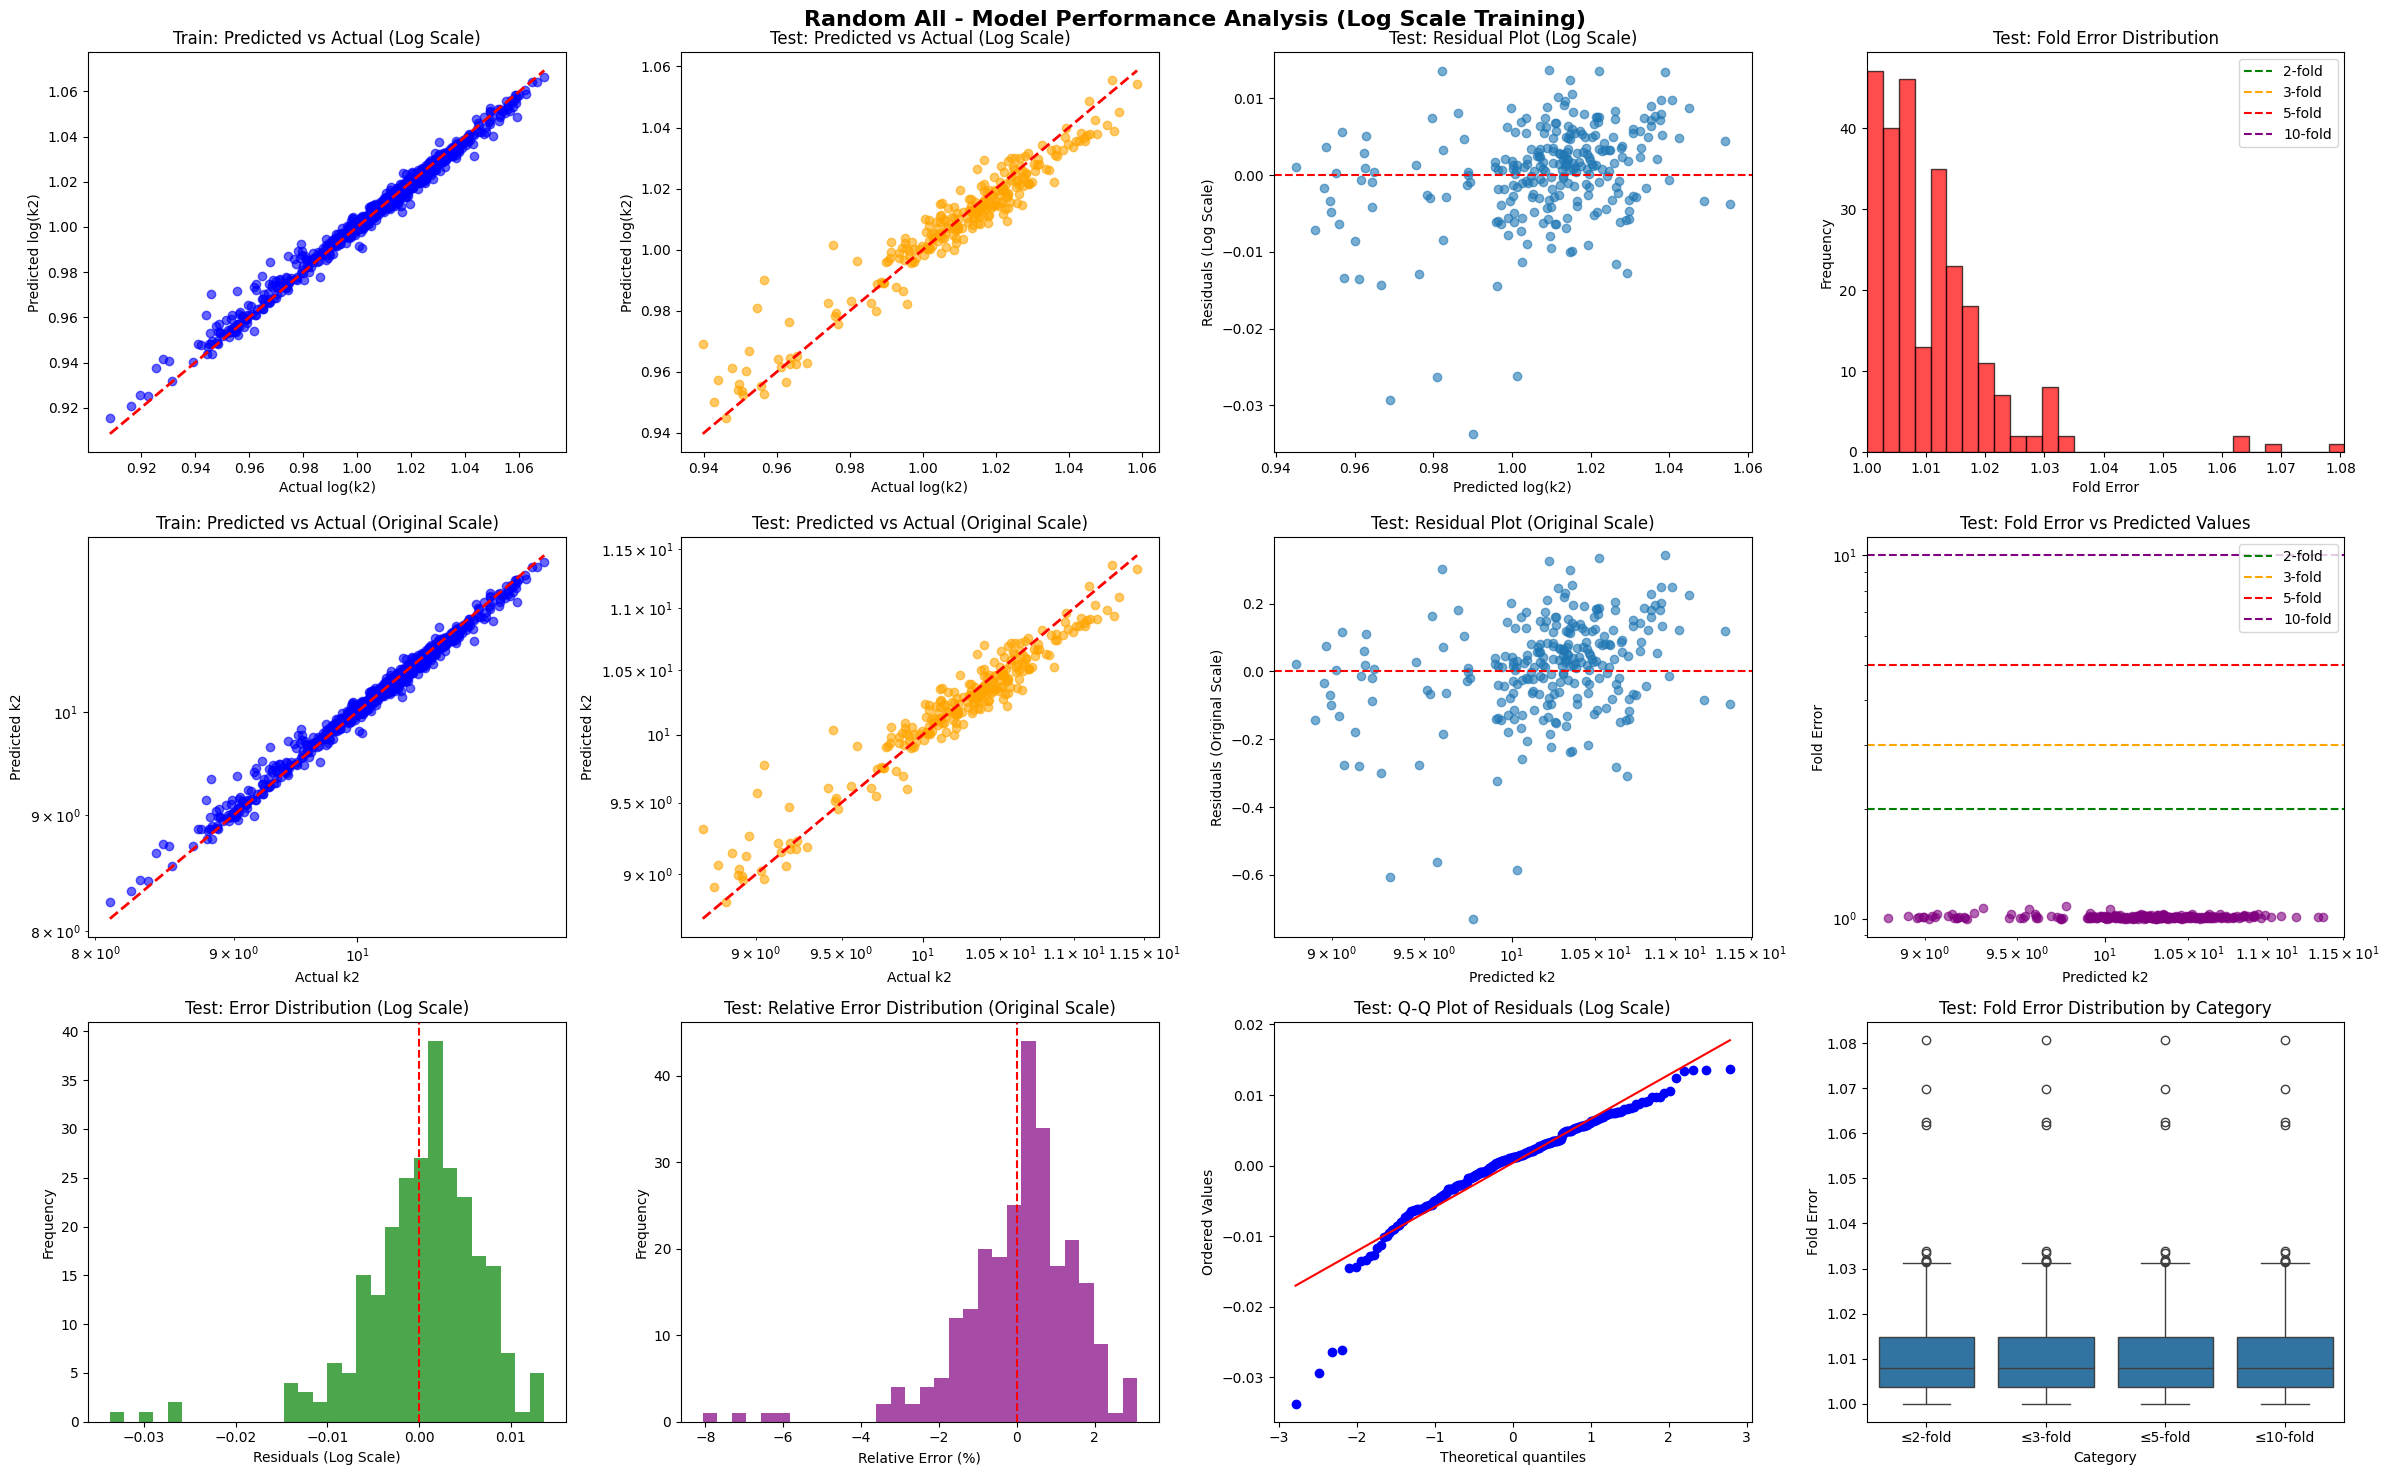

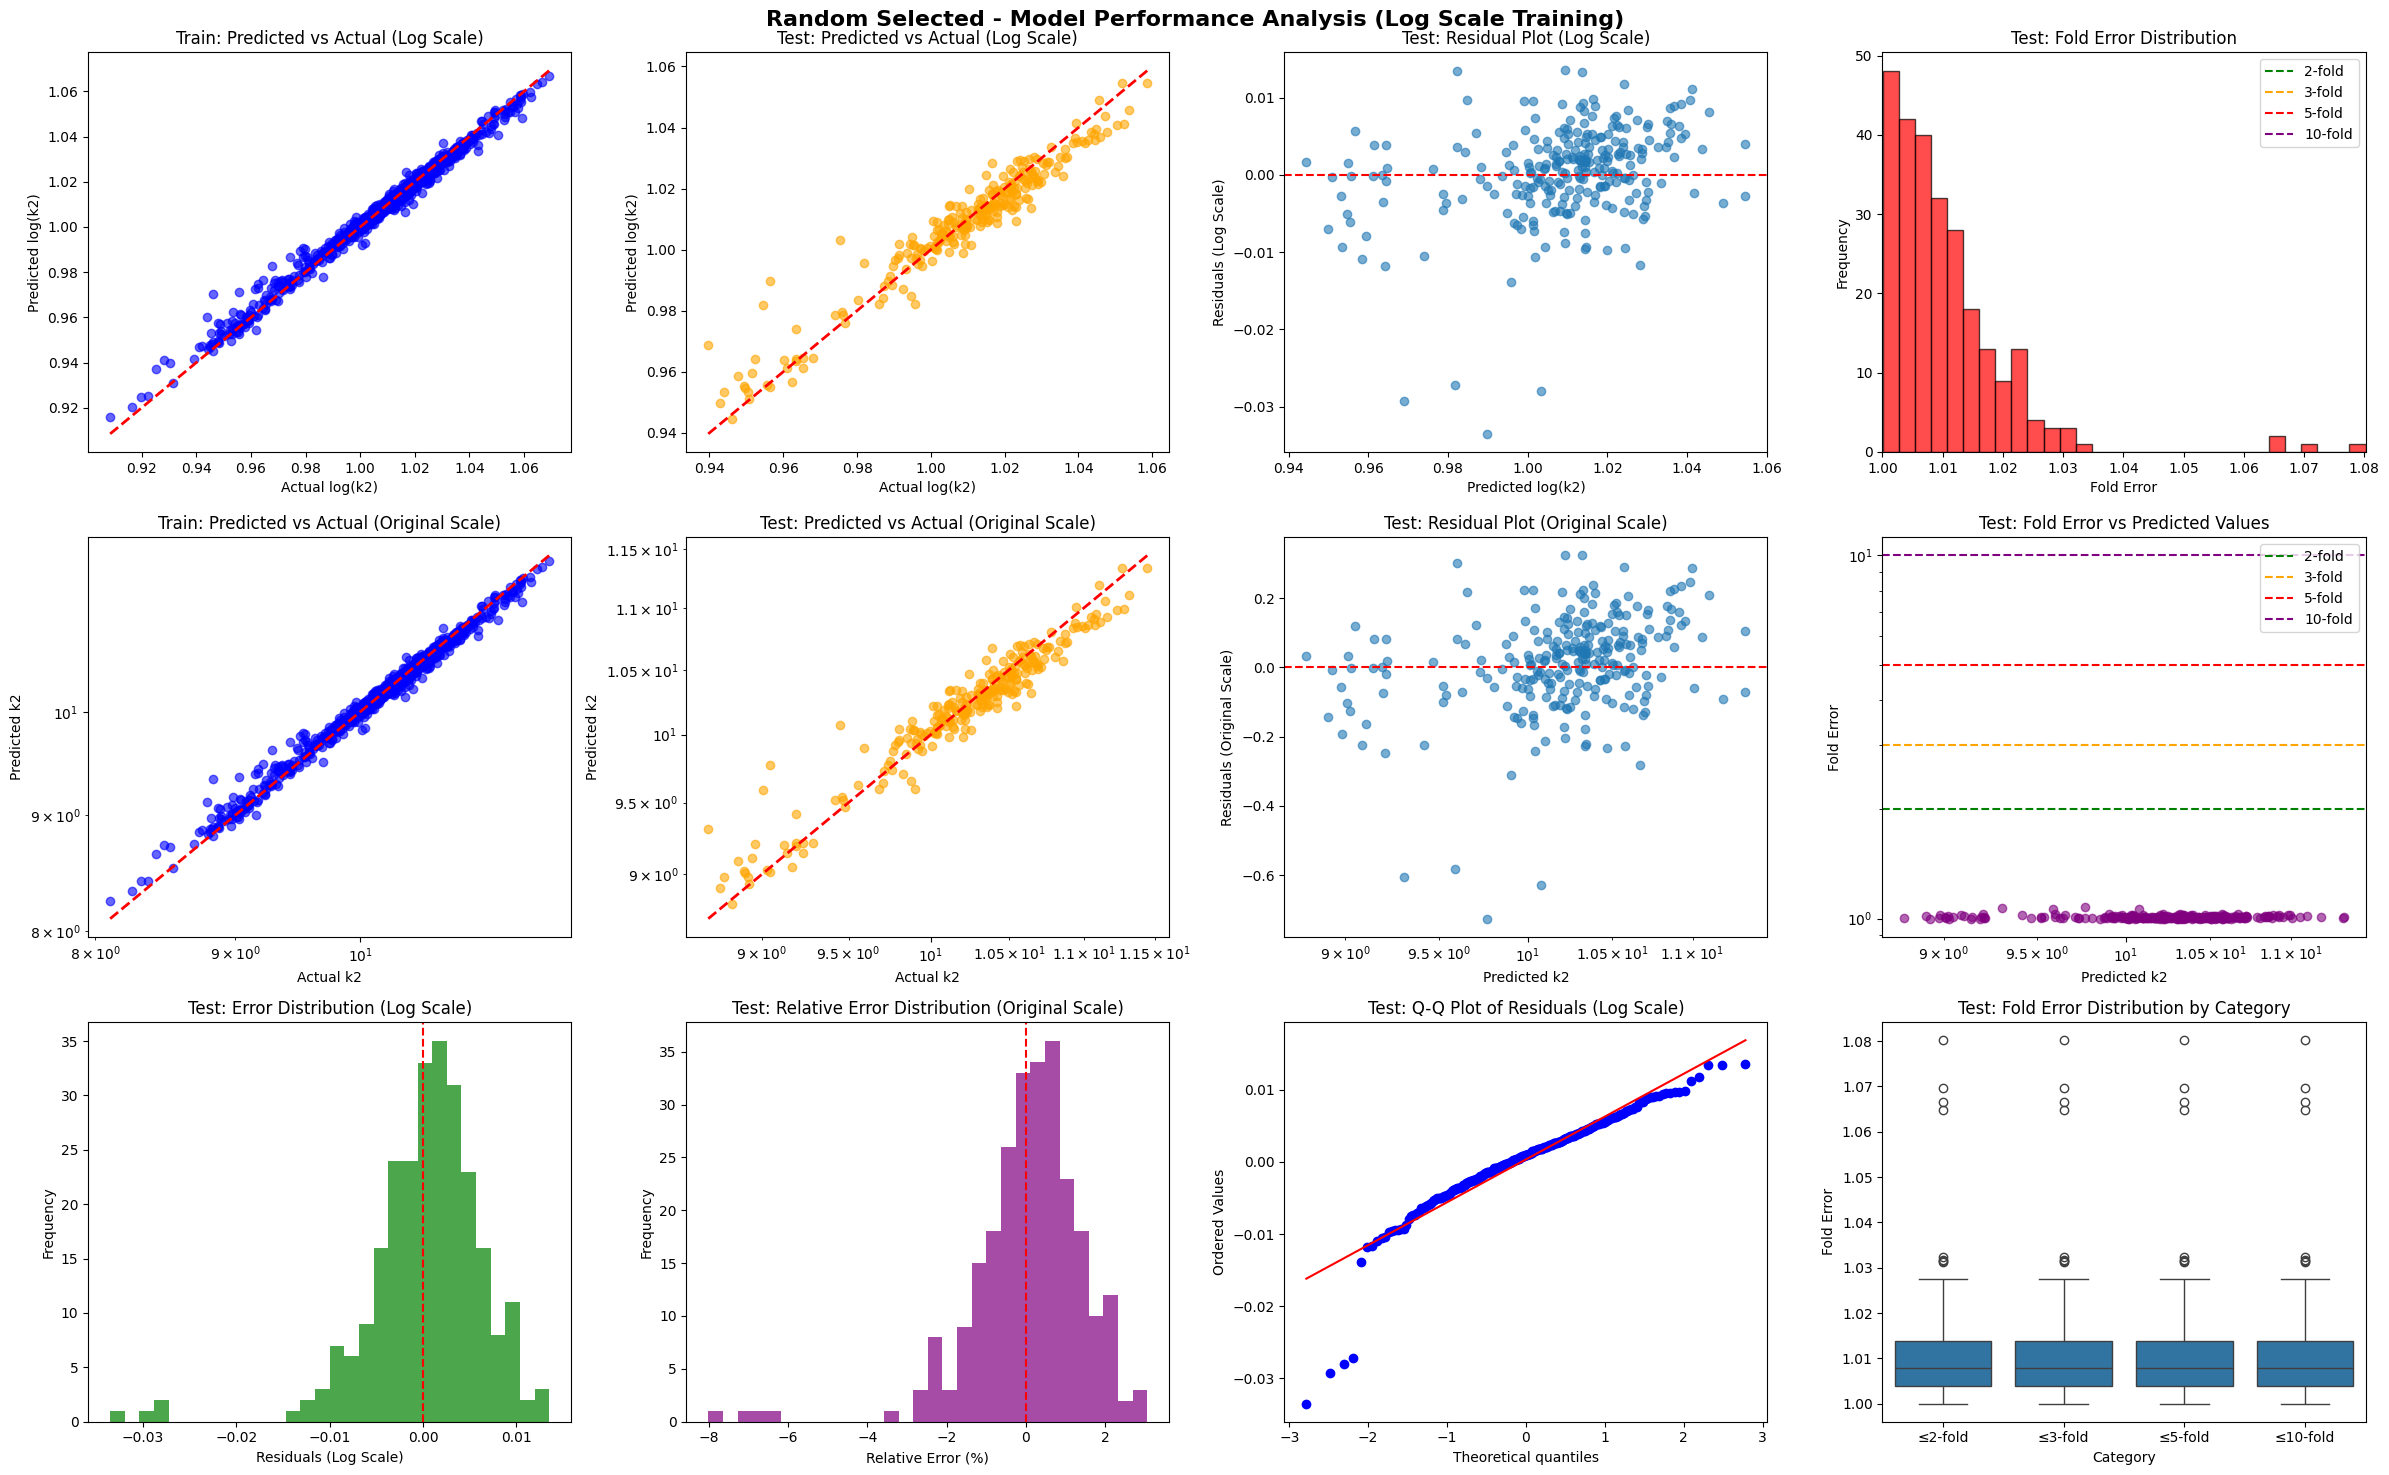

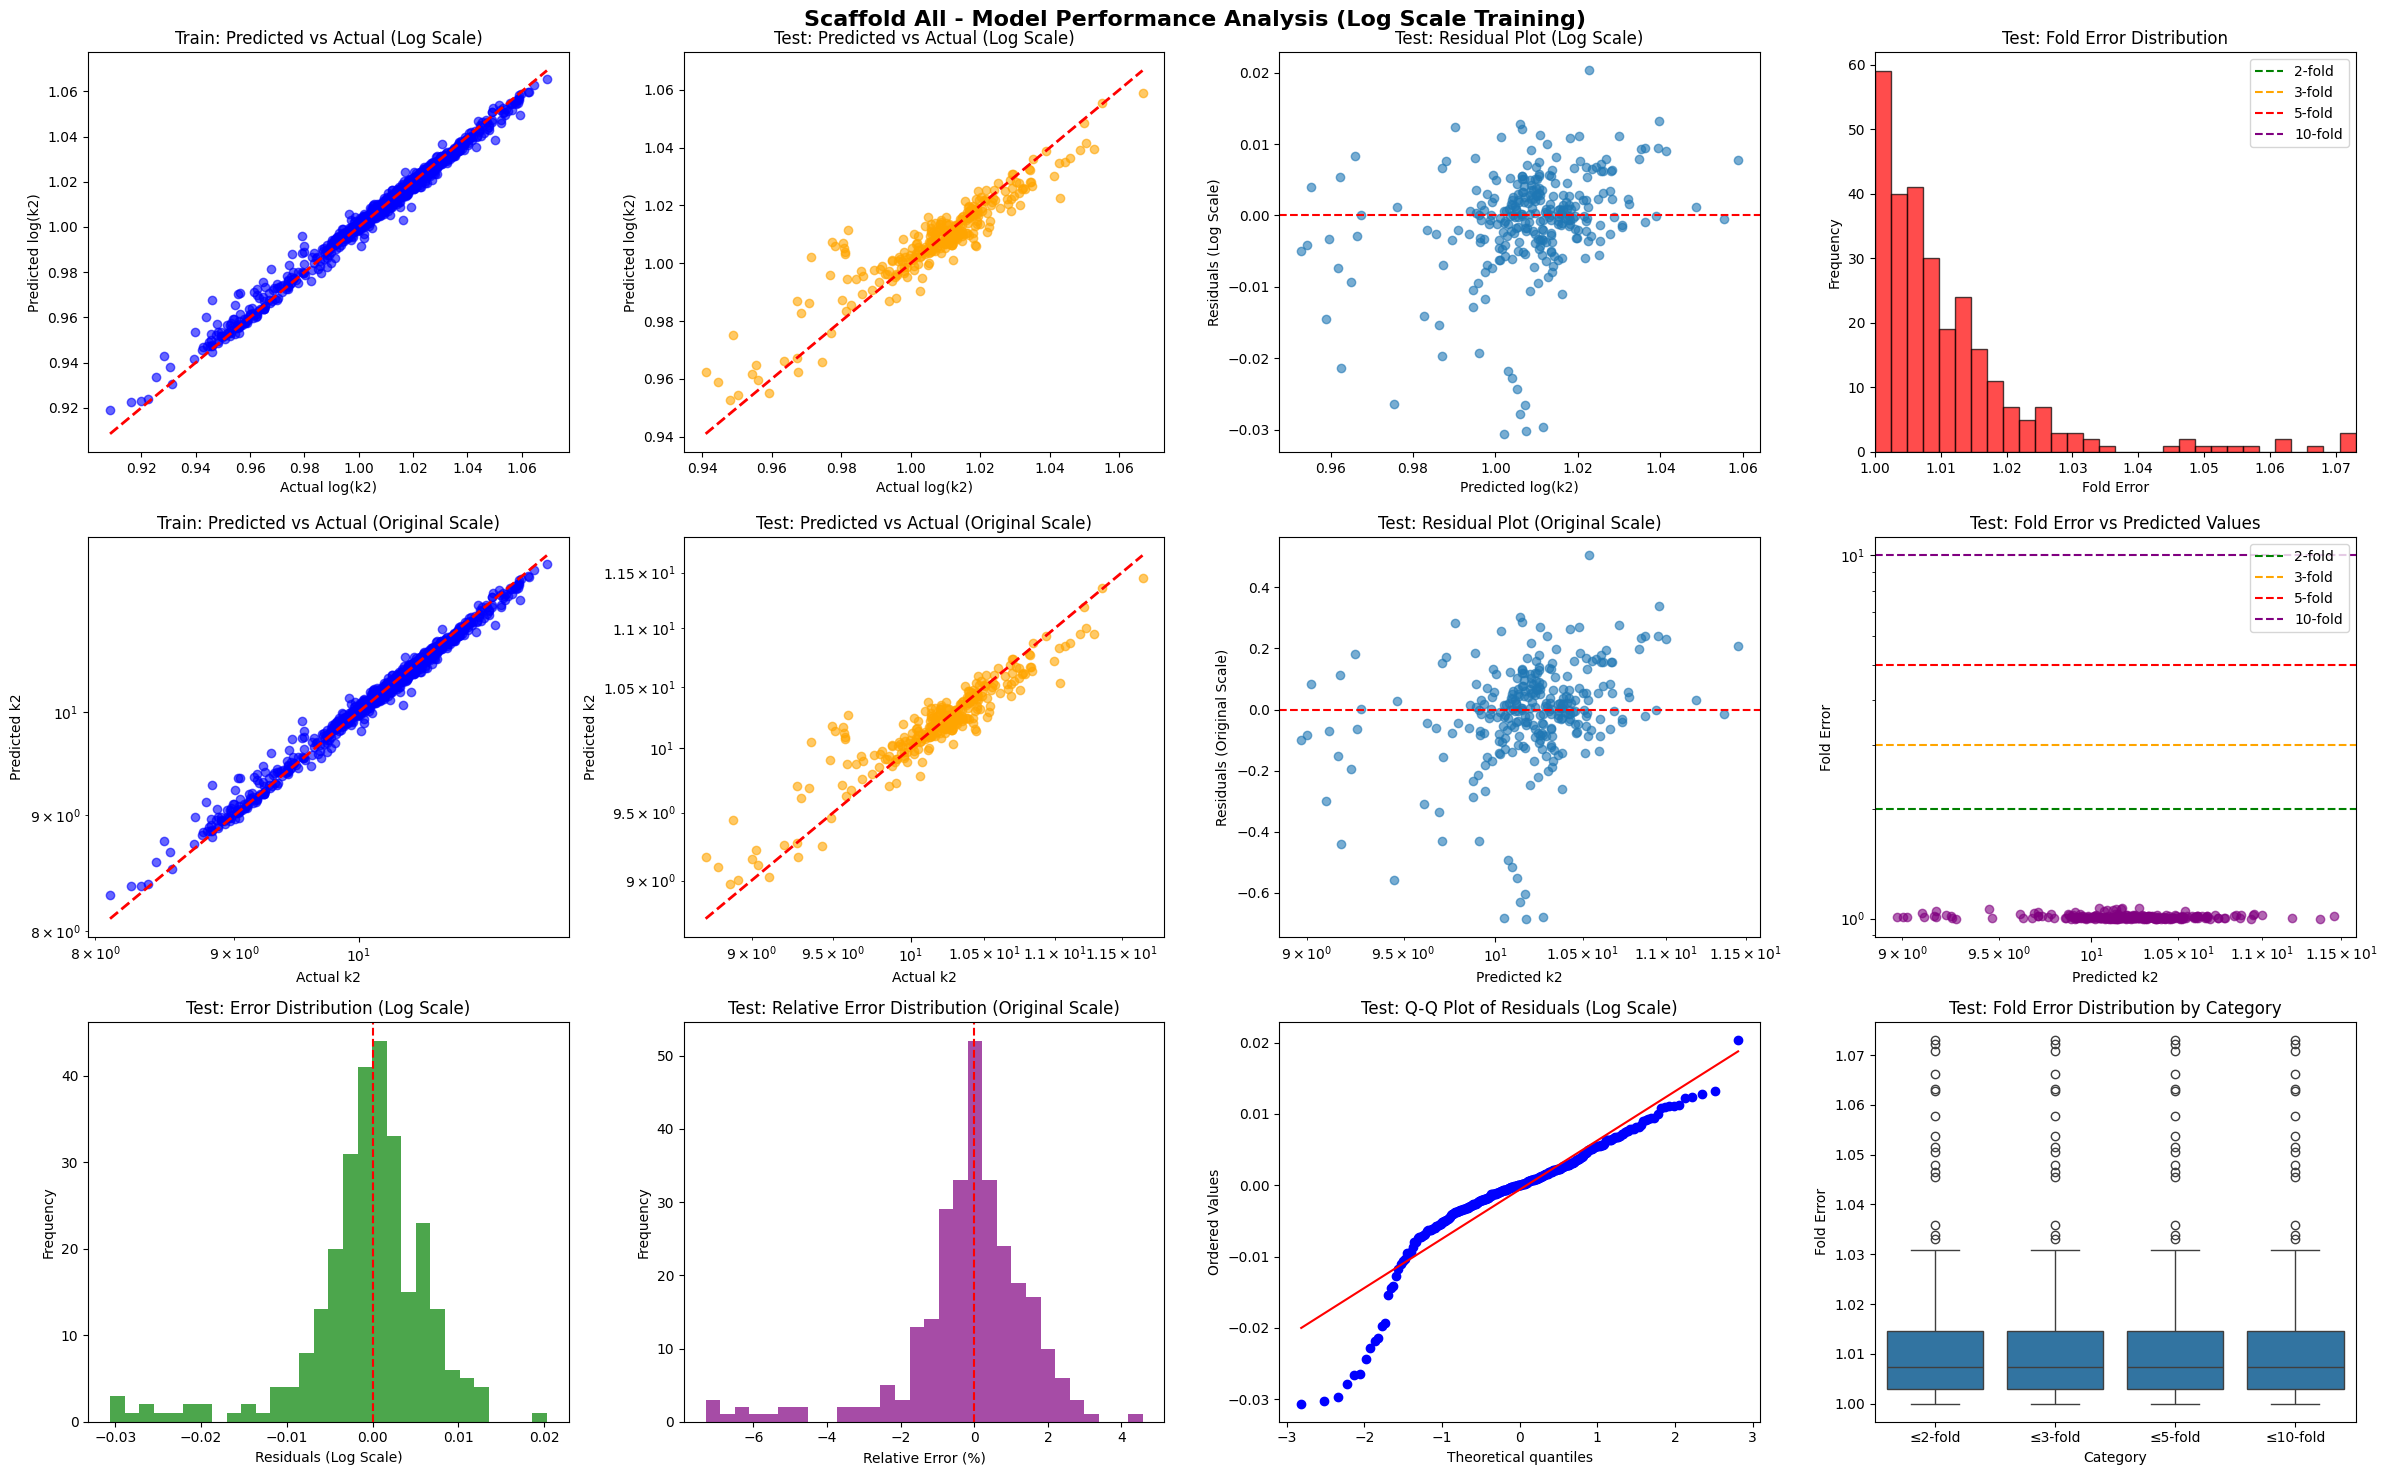

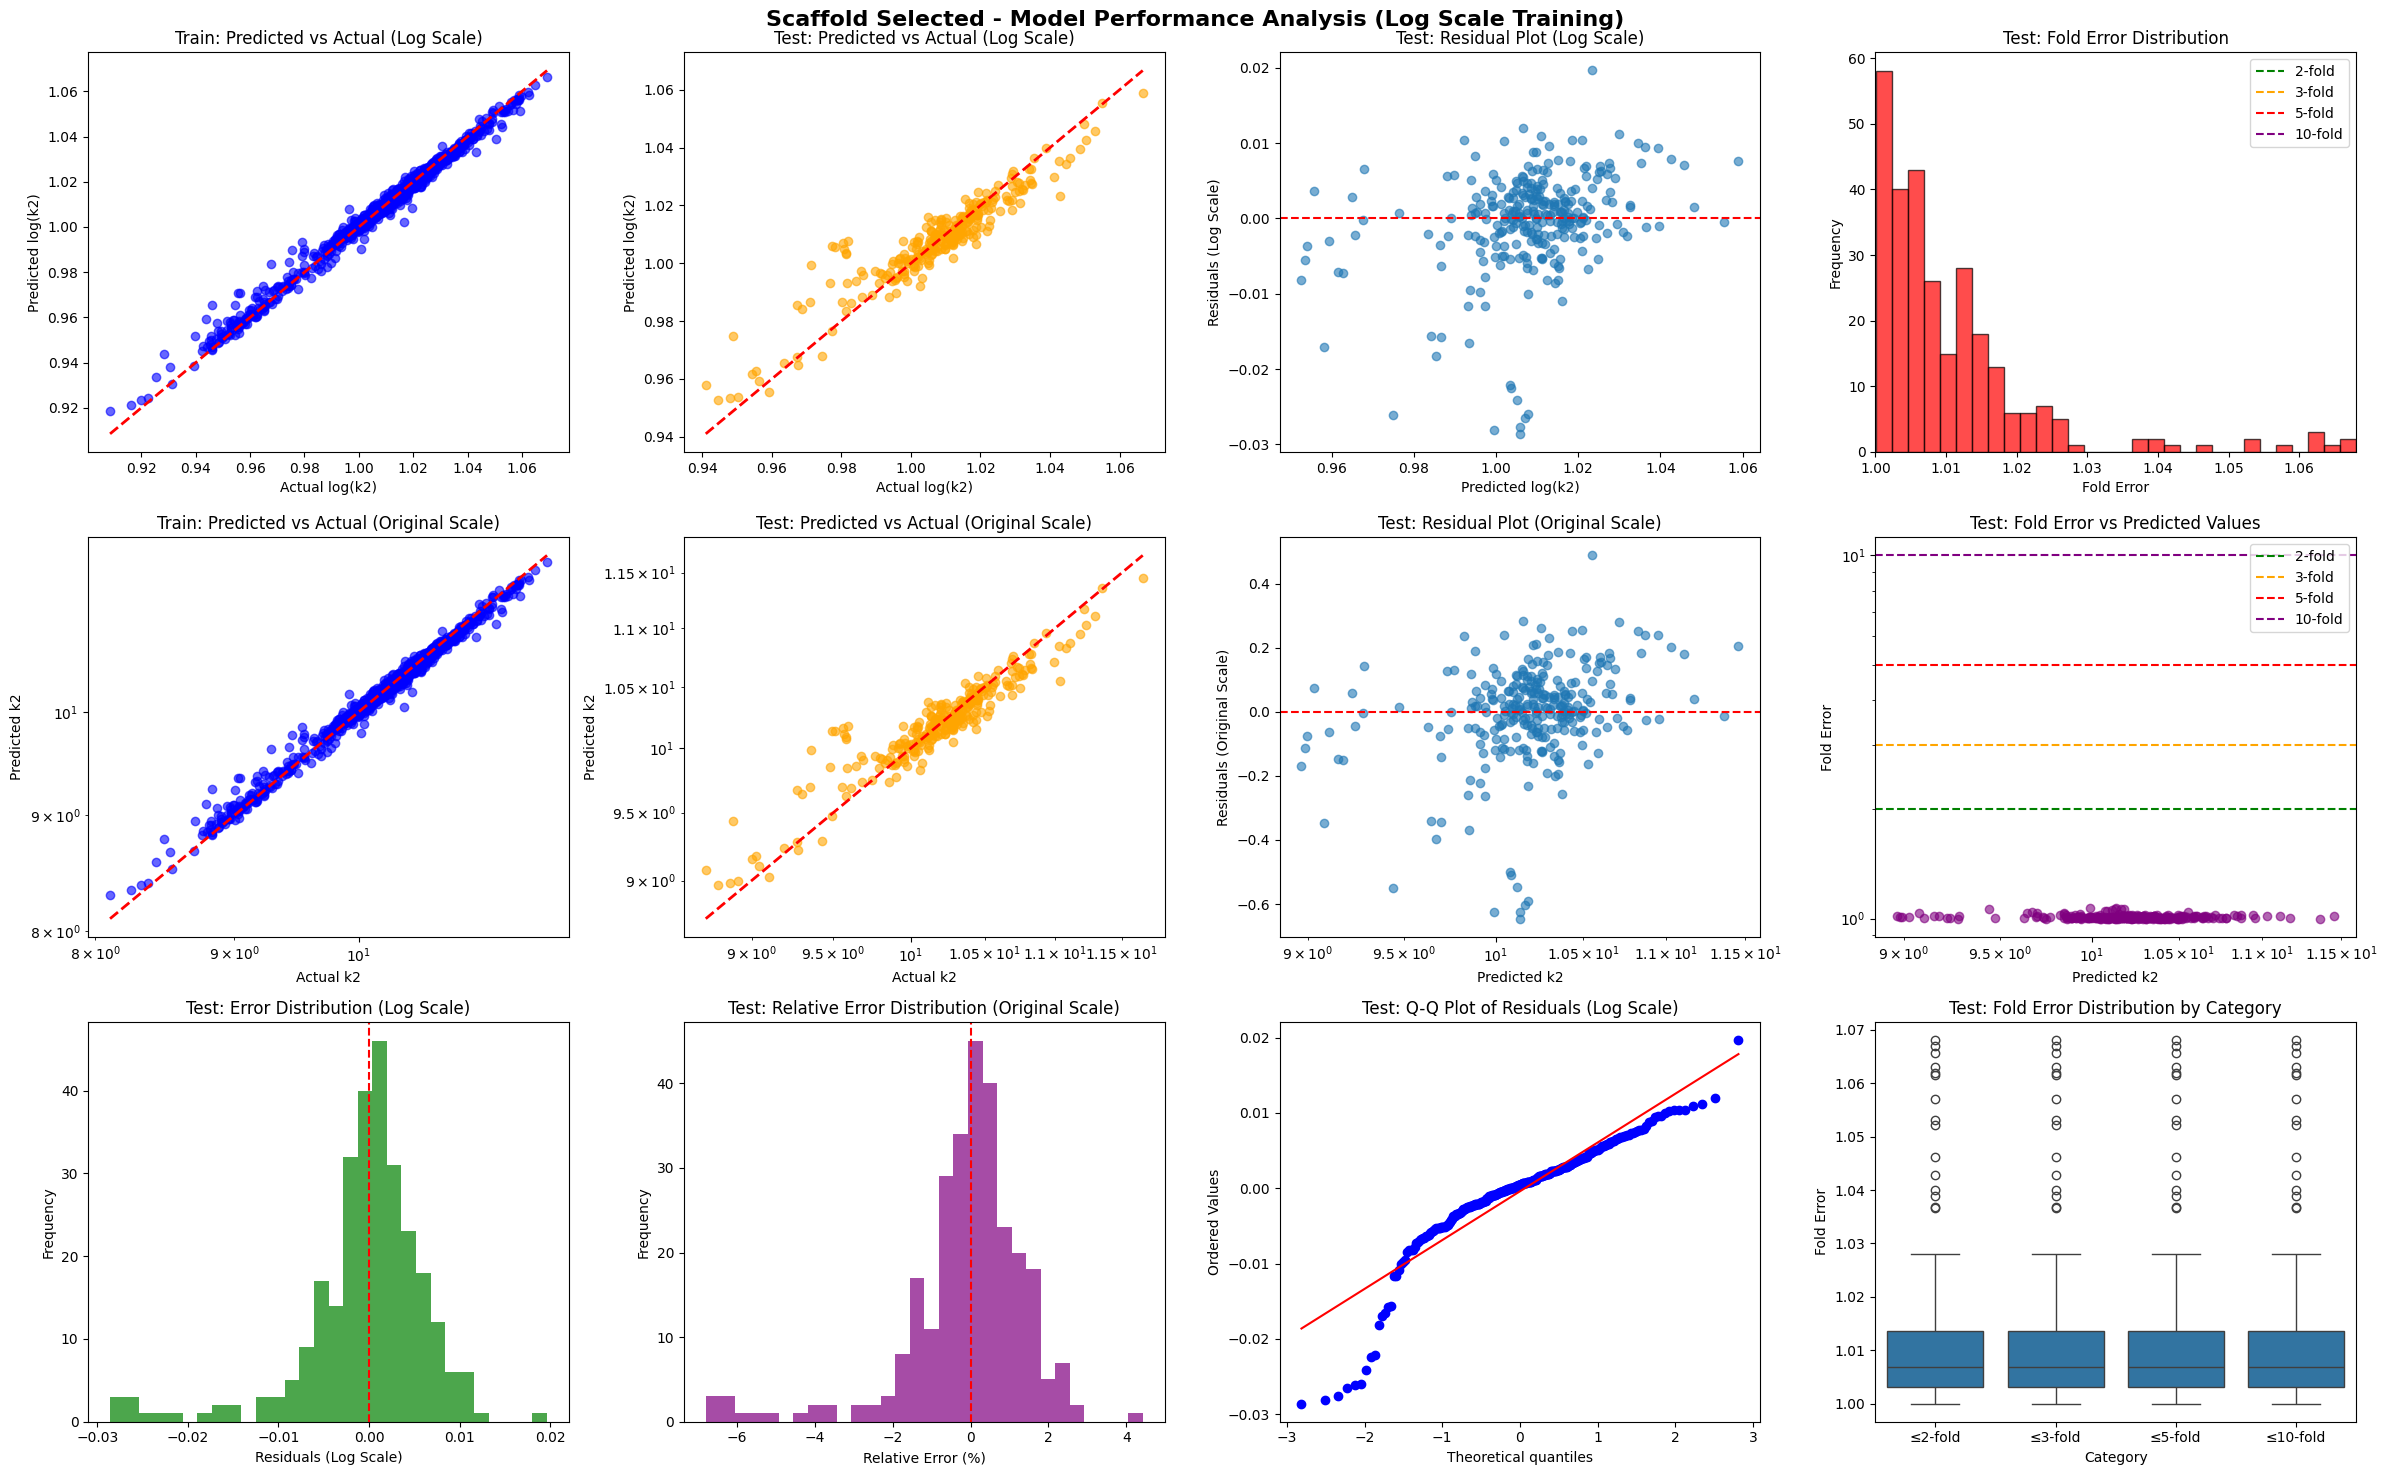

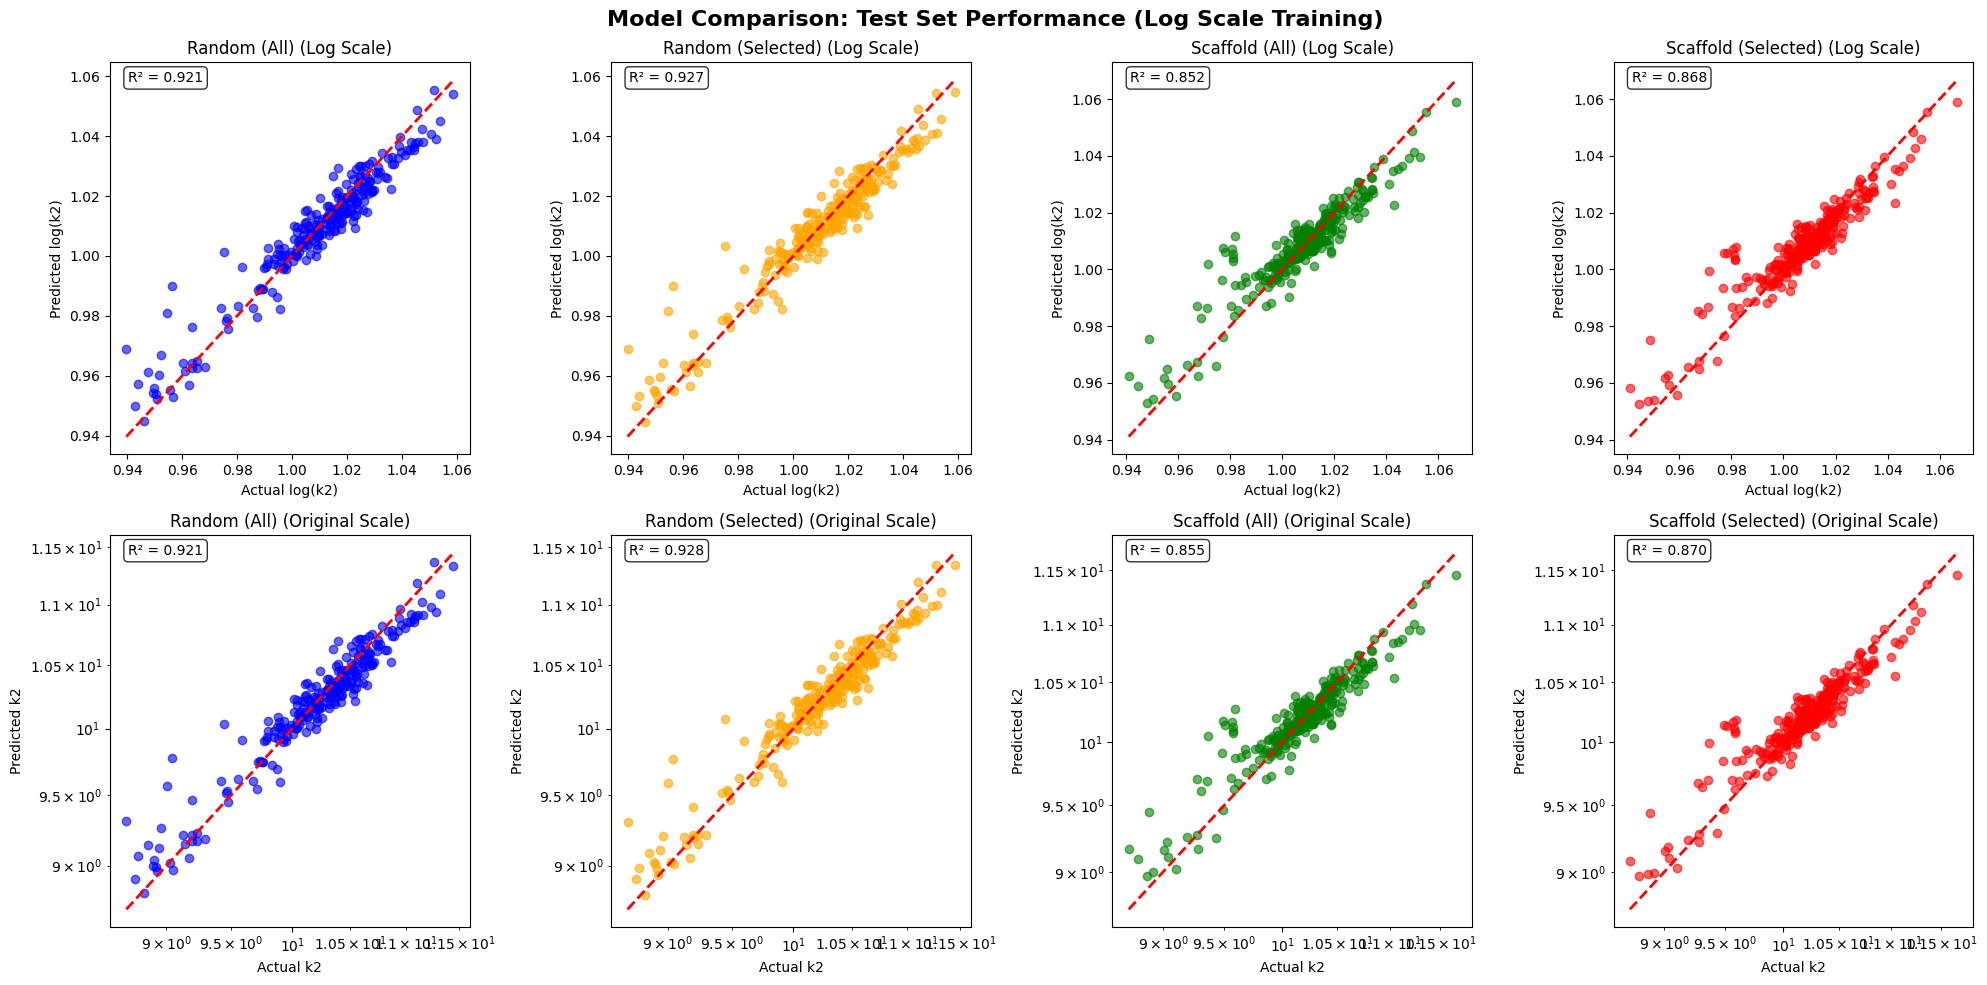

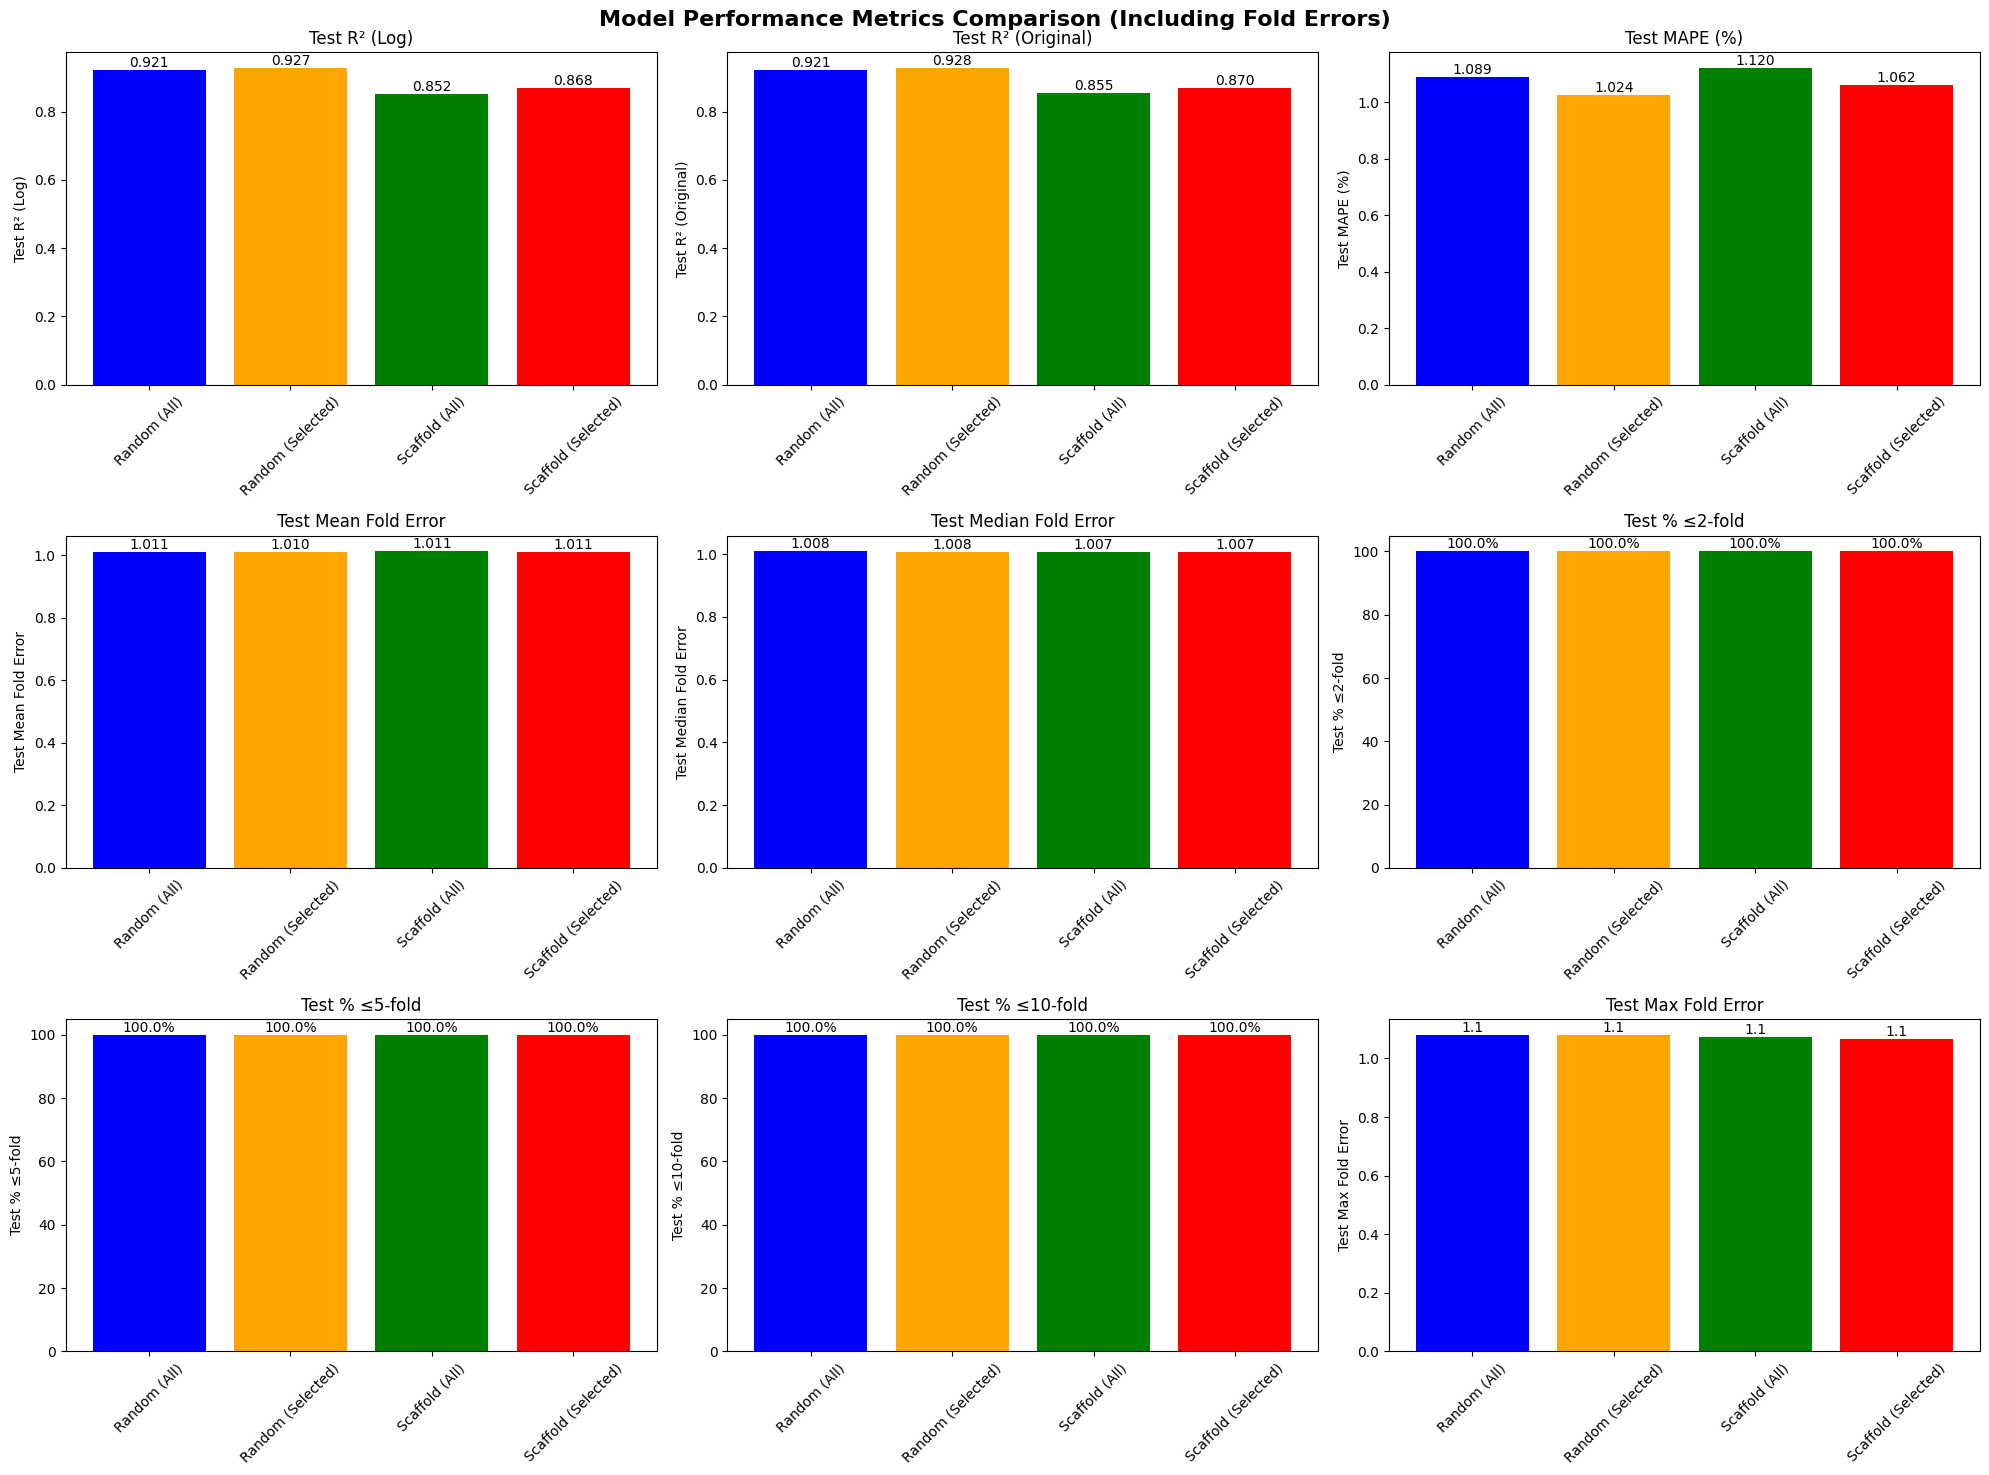

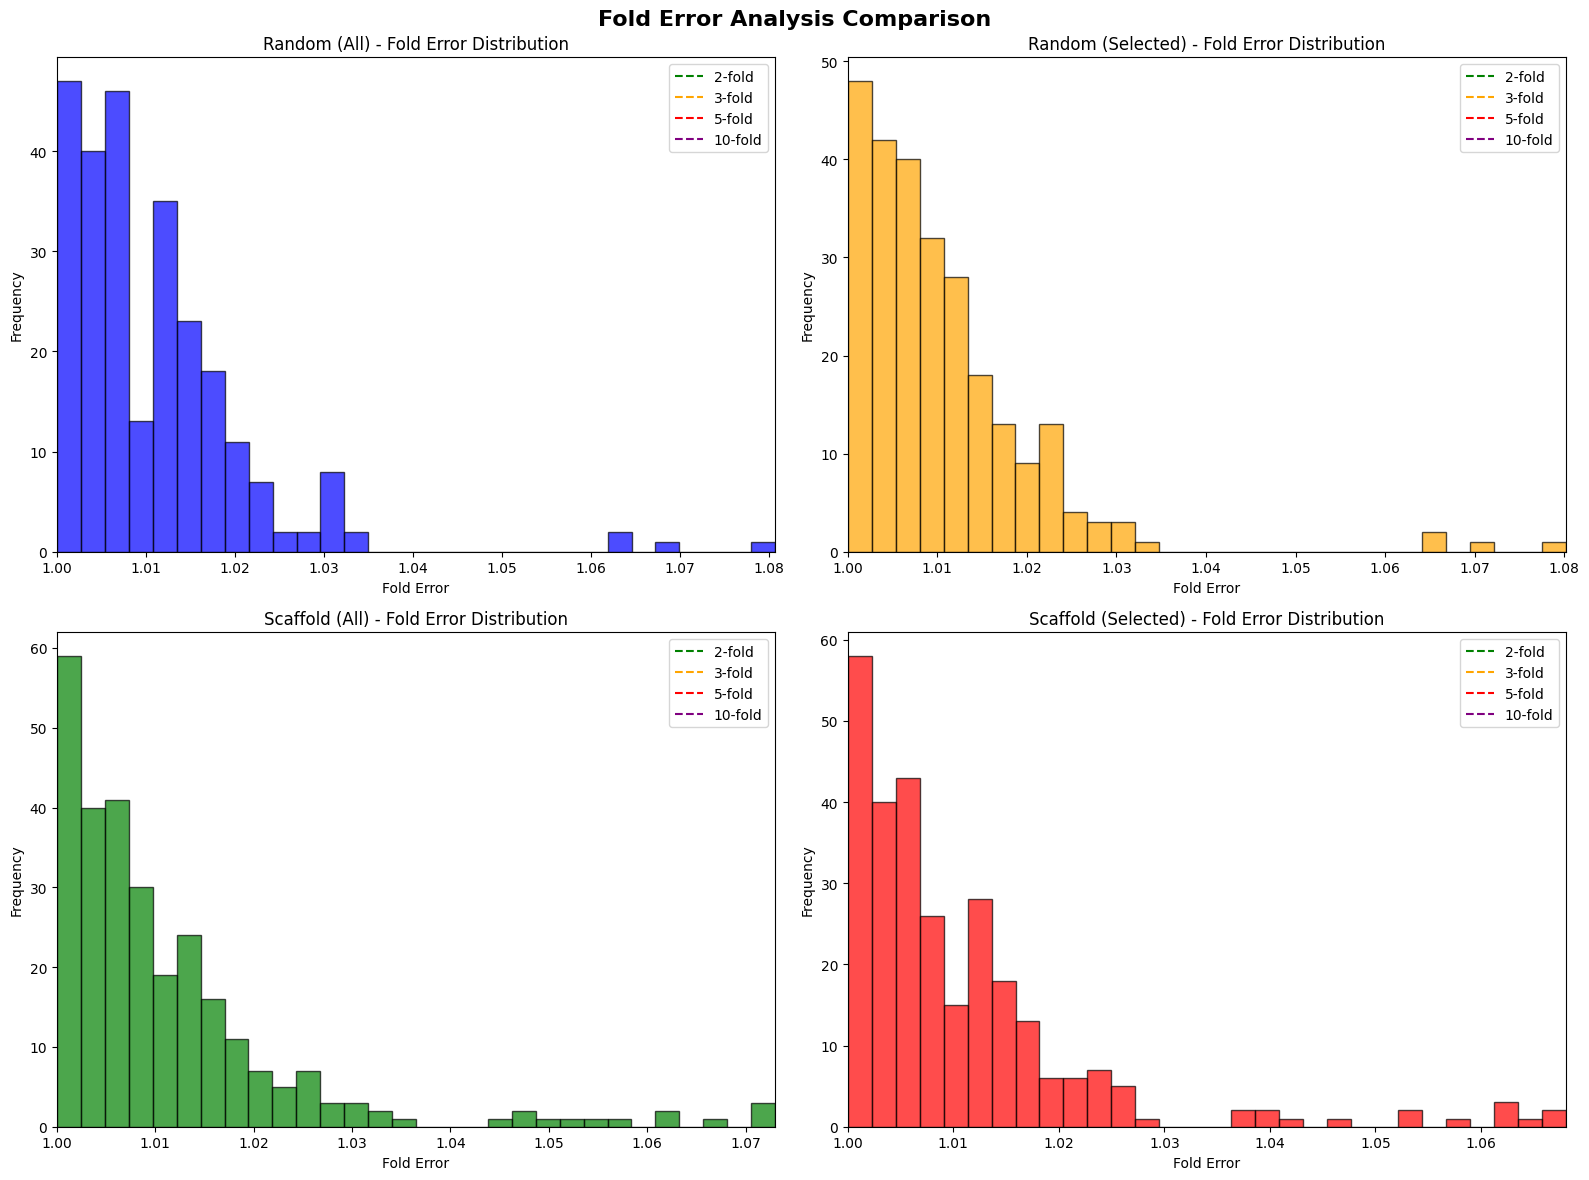


FEATURE IMPORTANCE ANALYSIS


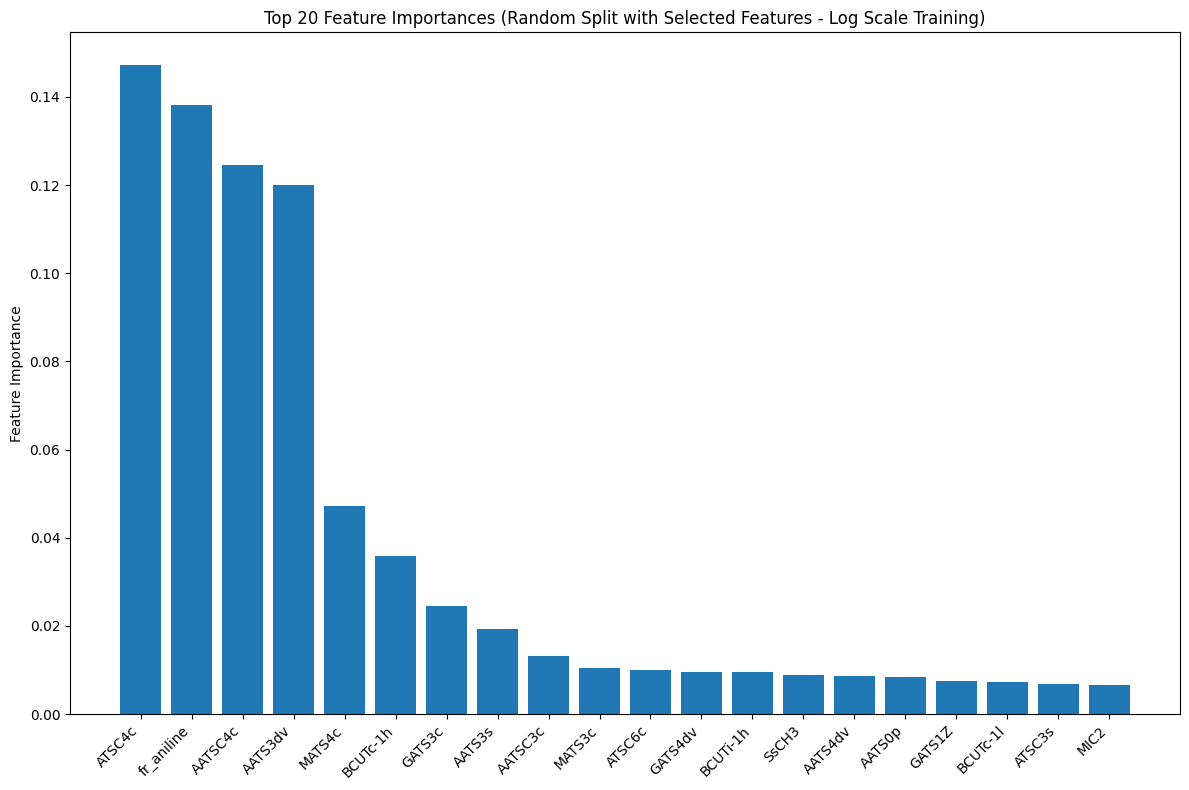


Top 10 Most Important Features:
 1. ATSC4c                    : 0.1473
 2. fr_aniline                : 0.1381
 3. AATSC4c                   : 0.1244
 4. AATS3dv                   : 0.1201
 5. MATS4c                    : 0.0471
 6. BCUTc-1h                  : 0.0358
 7. GATS3c                    : 0.0246
 8. AATS3s                    : 0.0194
 9. AATSC3c                   : 0.0132
10. MATS3c                    : 0.0105

FOLD ERROR ANALYSIS SUMMARY
                             Model Mean_Fold_Error Median_Fold_Error Within_2_Fold_% Within_3_Fold_% Within_5_Fold_% Within_10_Fold_% Max_Fold_Error
       Random Split (All Features)            1.01              1.01          100.0%          100.0%          100.0%           100.0%            1.1
  Random Split (Selected Features)            1.01              1.01          100.0%          100.0%          100.0%           100.0%            1.1
     Scaffold Split (All Features)            1.01              1.01          100.0%          100.0% 

In [135]:
### Evaluate Model Performance (Log Scale Training with Fold Errors)

def calculate_fold_errors(y_true, y_pred):
    """
    Calculate fold error metrics
    """
    # Ensure positive values (important for k2 data)
    y_true = np.abs(y_true)
    y_pred = np.abs(y_pred)
    
    # Calculate fold errors
    fold_errors = np.maximum(y_pred / y_true, y_true / y_pred)
    
    # Calculate fold error metrics
    fold_metrics = {
        'mean_fold_error': np.mean(fold_errors),
        'median_fold_error': np.median(fold_errors),
        'fold_2': np.mean(fold_errors <= 2) * 100,  # % within 2-fold
        'fold_3': np.mean(fold_errors <= 3) * 100,  # % within 3-fold
        'fold_5': np.mean(fold_errors <= 5) * 100,  # % within 5-fold
        'fold_10': np.mean(fold_errors <= 10) * 100, # % within 10-fold
        'max_fold_error': np.max(fold_errors),
        'std_fold_error': np.std(fold_errors)
    }
    
    return fold_metrics, fold_errors

def evaluate_model_comprehensive_log(model, X_train, X_test, y_train_log, y_test_log, model_name):
    """
    Comprehensive evaluation of regression model trained on log(k2) with multiple metrics including fold errors
    """
    # Make predictions (these will be in log scale since model was trained on log(k2))
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # Convert back to original scale
    y_train_original = 10**y_train_log
    y_test_original = 10**y_test_log
    y_train_pred_original = 10**y_train_pred_log
    y_test_pred_original = 10**y_test_pred_log
    
    # Calculate standard metrics in log scale (model's native scale)
    metrics = {
        'Model': model_name,
        'Train_R2_log': r2_score(y_train_log, y_train_pred_log),
        'Test_R2_log': r2_score(y_test_log, y_test_pred_log),
        'Train_MAE_log': mean_absolute_error(y_train_log, y_train_pred_log),
        'Test_MAE_log': mean_absolute_error(y_test_log, y_test_pred_log),
        'Train_RMSE_log': np.sqrt(mean_squared_error(y_train_log, y_train_pred_log)),
        'Test_RMSE_log': np.sqrt(mean_squared_error(y_test_log, y_test_pred_log)),
    }
    
    # Calculate standard metrics in original scale (for interpretability)
    metrics.update({
        'Train_R2_original': r2_score(y_train_original, y_train_pred_original),
        'Test_R2_original': r2_score(y_test_original, y_test_pred_original),
        'Train_MAE_original': mean_absolute_error(y_train_original, y_train_pred_original),
        'Test_MAE_original': mean_absolute_error(y_test_original, y_test_pred_original),
        'Train_RMSE_original': np.sqrt(mean_squared_error(y_train_original, y_train_pred_original)),
        'Test_RMSE_original': np.sqrt(mean_squared_error(y_test_original, y_test_pred_original)),
        'Train_MAPE_original': np.mean(np.abs((y_train_original - y_train_pred_original) / y_train_original)) * 100,
        'Test_MAPE_original': np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100
    })
    
    # Calculate fold error metrics
    train_fold_metrics, train_fold_errors = calculate_fold_errors(y_train_original, y_train_pred_original)
    test_fold_metrics, test_fold_errors = calculate_fold_errors(y_test_original, y_test_pred_original)
    
    # Add fold error metrics to main metrics dictionary
    for key, value in train_fold_metrics.items():
        metrics[f'Train_{key}'] = value
    for key, value in test_fold_metrics.items():
        metrics[f'Test_{key}'] = value
    
    return metrics, y_train_pred_log, y_test_pred_log, y_train_pred_original, y_test_pred_original, train_fold_errors, test_fold_errors

def plot_model_performance_log(y_train_log, y_test_log, y_train_pred_log, y_test_pred_log, 
                              y_train_original, y_test_original, y_train_pred_original, y_test_pred_original, 
                              train_fold_errors, test_fold_errors, model_name):
    """
    Create comprehensive plots for model performance (log scale training) including fold error analysis
    """
    fig, axes = plt.subplots(3, 4, figsize=(24, 15))
    fig.suptitle(f'{model_name} - Model Performance Analysis (Log Scale Training)', fontsize=16, fontweight='bold')
    
    # Row 1: Log scale analysis (model's native scale)
    # 1. Predicted vs Actual (Train, Log Scale)
    axes[0,0].scatter(y_train_log, y_train_pred_log, alpha=0.6, color='blue')
    axes[0,0].plot([y_train_log.min(), y_train_log.max()], [y_train_log.min(), y_train_log.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual log(k2)')
    axes[0,0].set_ylabel('Predicted log(k2)')
    axes[0,0].set_title('Train: Predicted vs Actual (Log Scale)')
    
    # 2. Predicted vs Actual (Test, Log Scale)
    axes[0,1].scatter(y_test_log, y_test_pred_log, alpha=0.6, color='orange')
    axes[0,1].plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual log(k2)')
    axes[0,1].set_ylabel('Predicted log(k2)')
    axes[0,1].set_title('Test: Predicted vs Actual (Log Scale)')
    
    # 3. Residual Plot (Test, Log Scale)
    residuals_log = y_test_log - y_test_pred_log
    axes[0,2].scatter(y_test_pred_log, residuals_log, alpha=0.6)
    axes[0,2].axhline(y=0, color='r', linestyle='--')
    axes[0,2].set_xlabel('Predicted log(k2)')
    axes[0,2].set_ylabel('Residuals (Log Scale)')
    axes[0,2].set_title('Test: Residual Plot (Log Scale)')
    
    # 4. Fold Error Distribution (Test)
    axes[0,3].hist(test_fold_errors, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0,3].axvline(x=2, color='green', linestyle='--', label='2-fold')
    axes[0,3].axvline(x=3, color='orange', linestyle='--', label='3-fold')
    axes[0,3].axvline(x=5, color='red', linestyle='--', label='5-fold')
    axes[0,3].axvline(x=10, color='purple', linestyle='--', label='10-fold')
    axes[0,3].set_xlabel('Fold Error')
    axes[0,3].set_ylabel('Frequency')
    axes[0,3].set_title('Test: Fold Error Distribution')
    axes[0,3].legend()
    axes[0,3].set_xlim(1, min(50, np.max(test_fold_errors)))
    
    # Row 2: Original scale analysis (for interpretation)
    # 5. Predicted vs Actual (Train, Original Scale)
    axes[1,0].scatter(y_train_original, y_train_pred_original, alpha=0.6, color='blue')
    axes[1,0].plot([y_train_original.min(), y_train_original.max()], [y_train_original.min(), y_train_original.max()], 'r--', lw=2)
    axes[1,0].set_xlabel('Actual k2')
    axes[1,0].set_ylabel('Predicted k2')
    axes[1,0].set_title('Train: Predicted vs Actual (Original Scale)')
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    
    # 6. Predicted vs Actual (Test, Original Scale)
    axes[1,1].scatter(y_test_original, y_test_pred_original, alpha=0.6, color='orange')
    axes[1,1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
    axes[1,1].set_xlabel('Actual k2')
    axes[1,1].set_ylabel('Predicted k2')
    axes[1,1].set_title('Test: Predicted vs Actual (Original Scale)')
    axes[1,1].set_xscale('log')
    axes[1,1].set_yscale('log')
    
    # 7. Residual Plot (Test, Original Scale)
    residuals_original = y_test_original - y_test_pred_original
    axes[1,2].scatter(y_test_pred_original, residuals_original, alpha=0.6)
    axes[1,2].axhline(y=0, color='r', linestyle='--')
    axes[1,2].set_xlabel('Predicted k2')
    axes[1,2].set_ylabel('Residuals (Original Scale)')
    axes[1,2].set_title('Test: Residual Plot (Original Scale)')
    axes[1,2].set_xscale('log')
    
    # 8. Fold Error vs Predicted Values
    axes[1,3].scatter(y_test_pred_original, test_fold_errors, alpha=0.6, color='purple')
    axes[1,3].axhline(y=2, color='green', linestyle='--', label='2-fold')
    axes[1,3].axhline(y=3, color='orange', linestyle='--', label='3-fold')
    axes[1,3].axhline(y=5, color='red', linestyle='--', label='5-fold')
    axes[1,3].axhline(y=10, color='purple', linestyle='--', label='10-fold')
    axes[1,3].set_xlabel('Predicted k2')
    axes[1,3].set_ylabel('Fold Error')
    axes[1,3].set_title('Test: Fold Error vs Predicted Values')
    axes[1,3].set_xscale('log')
    axes[1,3].set_yscale('log')
    axes[1,3].legend()
    
    # Row 3: Error analysis
    # 9. Error Distribution (Test, Log Scale)
    axes[2,0].hist(residuals_log, bins=30, alpha=0.7, color='green')
    axes[2,0].set_xlabel('Residuals (Log Scale)')
    axes[2,0].set_ylabel('Frequency')
    axes[2,0].set_title('Test: Error Distribution (Log Scale)')
    axes[2,0].axvline(x=0, color='r', linestyle='--')
    
    # 10. Relative Error Distribution (Original Scale)
    relative_error = (y_test_original - y_test_pred_original) / y_test_original * 100
    axes[2,1].hist(relative_error, bins=30, alpha=0.7, color='purple')
    axes[2,1].set_xlabel('Relative Error (%)')
    axes[2,1].set_ylabel('Frequency')
    axes[2,1].set_title('Test: Relative Error Distribution (Original Scale)')
    axes[2,1].axvline(x=0, color='r', linestyle='--')
    
    # 11. Q-Q Plot for residuals normality (Log Scale)
    stats.probplot(residuals_log, dist="norm", plot=axes[2,2])
    axes[2,2].set_title('Test: Q-Q Plot of Residuals (Log Scale)')
    
    # 12. Fold Error Statistics Box Plot
    fold_categories = []
    fold_values = []
    for threshold in [2, 3, 5, 10]:
        within_fold = test_fold_errors[test_fold_errors <= threshold]
        if len(within_fold) > 0:
            fold_categories.extend([f'≤{threshold}-fold'] * len(within_fold))
            fold_values.extend(within_fold)
    
    if len(fold_categories) > 0:
        fold_df = pd.DataFrame({'Category': fold_categories, 'Fold_Error': fold_values})
        sns.boxplot(data=fold_df, x='Category', y='Fold_Error', ax=axes[2,3])
        axes[2,3].set_title('Test: Fold Error Distribution by Category')
        axes[2,3].set_ylabel('Fold Error')
    else:
        axes[2,3].text(0.5, 0.5, 'No data within fold thresholds', ha='center', va='center', transform=axes[2,3].transAxes)
        axes[2,3].set_title('Test: Fold Error Distribution by Category')
    
    plt.tight_layout()
    plt.show()

# Store all results
all_results = []
all_predictions = {}

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION (LOG SCALE TRAINING WITH FOLD ERRORS)")
print("="*80)

# Convert y to log scale for training
y_log = np.log10(y)

# Random splits with log scale targets
X_train_random, X_test_random, y_train_random_log, y_test_random_log = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

X_train_random_selected, X_test_random_selected, _, _ = train_test_split(
    X_selected, y_log, test_size=0.2, random_state=42
)

# Scaffold splits with log scale targets
y_log_np = np.asarray(y_log)
y_train_scaffold_log = y_log_np[train_idx]
y_test_scaffold_log = y_log_np[test_idx]

# 1. Random Split Without Cleaned Data
print("\n1. Random Split WITHOUT Cleaned Data:")
rf1 = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
rf1.fit(X_train_random, y_train_random_log)

metrics1, y_train_pred1_log, y_test_pred1_log, y_train_pred1_orig, y_test_pred1_orig, train_fold1, test_fold1 = evaluate_model_comprehensive_log(
    rf1, X_train_random, X_test_random, y_train_random_log, y_test_random_log, 
    "Random Split (All Features)"
)
all_results.append(metrics1)
all_predictions['random_all'] = {
    'log': (y_train_random_log, y_test_random_log, y_train_pred1_log, y_test_pred1_log),
    'original': (10**y_train_random_log, 10**y_test_random_log, y_train_pred1_orig, y_test_pred1_orig),
    'fold_errors': (train_fold1, test_fold1)
}

print(f"   Train R² (log): {metrics1['Train_R2_log']:.3f} | Test R² (log): {metrics1['Test_R2_log']:.3f}")
print(f"   Train R² (orig): {metrics1['Train_R2_original']:.3f} | Test R² (orig): {metrics1['Test_R2_original']:.3f}")
print(f"   Test MAPE: {metrics1['Test_MAPE_original']:.1f}% | Test Mean Fold Error: {metrics1['Test_mean_fold_error']:.2f}")
print(f"   Test % within 2-fold: {metrics1['Test_fold_2']:.1f}% | Test % within 5-fold: {metrics1['Test_fold_5']:.1f}%")

# 2. Random Split With Cleaned Data
print("\n2. Random Split WITH Cleaned Data:")
rf2 = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
rf2.fit(X_train_random_selected, y_train_random_log)

metrics2, y_train_pred2_log, y_test_pred2_log, y_train_pred2_orig, y_test_pred2_orig, train_fold2, test_fold2 = evaluate_model_comprehensive_log(
    rf2, X_train_random_selected, X_test_random_selected, y_train_random_log, y_test_random_log, 
    "Random Split (Selected Features)"
)
all_results.append(metrics2)
all_predictions['random_selected'] = {
    'log': (y_train_random_log, y_test_random_log, y_train_pred2_log, y_test_pred2_log),
    'original': (10**y_train_random_log, 10**y_test_random_log, y_train_pred2_orig, y_test_pred2_orig),
    'fold_errors': (train_fold2, test_fold2)
}

print(f"   Train R² (log): {metrics2['Train_R2_log']:.3f} | Test R² (log): {metrics2['Test_R2_log']:.3f}")
print(f"   Train R² (orig): {metrics2['Train_R2_original']:.3f} | Test R² (orig): {metrics2['Test_R2_original']:.3f}")
print(f"   Test MAPE: {metrics2['Test_MAPE_original']:.1f}% | Test Mean Fold Error: {metrics2['Test_mean_fold_error']:.2f}")
print(f"   Test % within 2-fold: {metrics2['Test_fold_2']:.1f}% | Test % within 5-fold: {metrics2['Test_fold_5']:.1f}%")

# 3. Scaffold Split WITHOUT Cleaned Data
print("\n3. Scaffold Split WITHOUT Cleaned Data:")
rf3 = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
rf3.fit(X_train_scaffold, y_train_scaffold_log)

metrics3, y_train_pred3_log, y_test_pred3_log, y_train_pred3_orig, y_test_pred3_orig, train_fold3, test_fold3 = evaluate_model_comprehensive_log(
    rf3, X_train_scaffold, X_test_scaffold, y_train_scaffold_log, y_test_scaffold_log, 
    "Scaffold Split (All Features)"
)
all_results.append(metrics3)
all_predictions['scaffold_all'] = {
    'log': (y_train_scaffold_log, y_test_scaffold_log, y_train_pred3_log, y_test_pred3_log),
    'original': (10**y_train_scaffold_log, 10**y_test_scaffold_log, y_train_pred3_orig, y_test_pred3_orig),
    'fold_errors': (train_fold3, test_fold3)
}

print(f"   Train R² (log): {metrics3['Train_R2_log']:.3f} | Test R² (log): {metrics3['Test_R2_log']:.3f}")
print(f"   Train R² (orig): {metrics3['Train_R2_original']:.3f} | Test R² (orig): {metrics3['Test_R2_original']:.3f}")
print(f"   Test MAPE: {metrics3['Test_MAPE_original']:.1f}% | Test Mean Fold Error: {metrics3['Test_mean_fold_error']:.2f}")
print(f"   Test % within 2-fold: {metrics3['Test_fold_2']:.1f}% | Test % within 5-fold: {metrics3['Test_fold_5']:.1f}%")

# 4. Scaffold Split WITH Cleaned Data
print("\n4. Scaffold Split WITH Cleaned Data:")
rf4 = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
rf4.fit(X_train_scaffold_selected, y_train_scaffold_log)

metrics4, y_train_pred4_log, y_test_pred4_log, y_train_pred4_orig, y_test_pred4_orig, train_fold4, test_fold4 = evaluate_model_comprehensive_log(
    rf4, X_train_scaffold_selected, X_test_scaffold_selected, y_train_scaffold_log, y_test_scaffold_log, 
    "Scaffold Split (Selected Features)"
)
all_results.append(metrics4)
all_predictions['scaffold_selected'] = {
    'log': (y_train_scaffold_log, y_test_scaffold_log, y_train_pred4_log, y_test_pred4_log),
    'original': (10**y_train_scaffold_log, 10**y_test_scaffold_log, y_train_pred4_orig, y_test_pred4_orig),
    'fold_errors': (train_fold4, test_fold4)
}

print(f"   Train R² (log): {metrics4['Train_R2_log']:.3f} | Test R² (log): {metrics4['Test_R2_log']:.3f}")
print(f"   Train R² (orig): {metrics4['Train_R2_original']:.3f} | Test R² (orig): {metrics4['Test_R2_original']:.3f}")
print(f"   Test MAPE: {metrics4['Test_MAPE_original']:.1f}% | Test Mean Fold Error: {metrics4['Test_mean_fold_error']:.2f}")
print(f"   Test % within 2-fold: {metrics4['Test_fold_2']:.1f}% | Test % within 5-fold: {metrics4['Test_fold_5']:.1f}%")

# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON (LOG SCALE TRAINING WITH FOLD ERRORS)")
print("="*80)
print(results_df.round(3))

# Plot performance for each model (including fold errors)
for key, predictions in all_predictions.items():
    model_name = key.replace('_', ' ').title()
    y_train_log, y_test_log, y_train_pred_log, y_test_pred_log = predictions['log']
    y_train_orig, y_test_orig, y_train_pred_orig, y_test_pred_orig = predictions['original']
    train_fold_errors, test_fold_errors = predictions['fold_errors']
    
    plot_model_performance_log(y_train_log, y_test_log, y_train_pred_log, y_test_pred_log,
                              y_train_orig, y_test_orig, y_train_pred_orig, y_test_pred_orig,
                              train_fold_errors, test_fold_errors, model_name)

# Model comparison plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Model Comparison: Test Set Performance (Log Scale Training)', fontsize=16, fontweight='bold')

colors = ['blue', 'orange', 'green', 'red']
model_names = ['Random (All)', 'Random (Selected)', 'Scaffold (All)', 'Scaffold (Selected)']

# Top row: Log scale comparison
for i, (key, predictions) in enumerate(all_predictions.items()):
    y_train_log, y_test_log, y_train_pred_log, y_test_pred_log = predictions['log']
    
    axes[0, i].scatter(y_test_log, y_test_pred_log, alpha=0.6, color=colors[i])
    axes[0, i].plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--', lw=2)
    axes[0, i].set_xlabel('Actual log(k2)')
    axes[0, i].set_ylabel('Predicted log(k2)')
    axes[0, i].set_title(f'{model_names[i]} (Log Scale)')
    
    # Add R² annotation
    r2_log = r2_score(y_test_log, y_test_pred_log)
    axes[0, i].text(0.05, 0.95, f'R² = {r2_log:.3f}', transform=axes[0, i].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# Bottom row: Original scale comparison
for i, (key, predictions) in enumerate(all_predictions.items()):
    y_train_orig, y_test_orig, y_train_pred_orig, y_test_pred_orig = predictions['original']
    
    axes[1, i].scatter(y_test_orig, y_test_pred_orig, alpha=0.6, color=colors[i])
    axes[1, i].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
    axes[1, i].set_xlabel('Actual k2')
    axes[1, i].set_ylabel('Predicted k2')
    axes[1, i].set_title(f'{model_names[i]} (Original Scale)')
    axes[1, i].set_xscale('log')
    axes[1, i].set_yscale('log')
    
    # Add R² annotation
    r2_orig = r2_score(y_test_orig, y_test_pred_orig)
    axes[1, i].text(0.05, 0.95, f'R² = {r2_orig:.3f}', transform=axes[1, i].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Enhanced performance metrics comparison (including fold error metrics)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Model Performance Metrics Comparison (Including Fold Errors)', fontsize=16, fontweight='bold')

metrics_to_plot = ['Test_R2_log', 'Test_R2_original', 'Test_MAPE_original', 
                   'Test_mean_fold_error', 'Test_median_fold_error', 'Test_fold_2', 
                   'Test_fold_5', 'Test_fold_10', 'Test_max_fold_error']
metric_titles = ['Test R² (Log)', 'Test R² (Original)', 'Test MAPE (%)', 
                'Test Mean Fold Error', 'Test Median Fold Error', 'Test % ≤2-fold', 
                'Test % ≤5-fold', 'Test % ≤10-fold', 'Test Max Fold Error']

for i, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    row, col = i // 3, i % 3
    values = [result[metric] for result in all_results]
    
    bars = axes[row, col].bar(model_names, values, color=colors)
    axes[row, col].set_title(title)
    axes[row, col].set_ylabel(title)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if 'fold_' in metric and metric.endswith(('_2', '_5', '_10')):
            # Percentage metrics
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{value:.1f}%', ha='center', va='bottom')
        elif 'max_fold_error' in metric:
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{value:.1f}', ha='center', va='bottom')
        else:
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{value:.3f}', ha='center', va='bottom')
    
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Fold Error Comparison Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fold Error Analysis Comparison', fontsize=16, fontweight='bold')

for i, (key, predictions) in enumerate(all_predictions.items()):
    row, col = i // 2, i % 2
    train_fold_errors, test_fold_errors = predictions['fold_errors']
    
    # Plot fold error distribution
    axes[row, col].hist(test_fold_errors, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    axes[row, col].axvline(x=2, color='green', linestyle='--', label='2-fold')
    axes[row, col].axvline(x=3, color='orange', linestyle='--', label='3-fold')
    axes[row, col].axvline(x=5, color='red', linestyle='--', label='5-fold')
    axes[row, col].axvline(x=10, color='purple', linestyle='--', label='10-fold')
    axes[row, col].set_xlabel('Fold Error')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{model_names[i]} - Fold Error Distribution')
    axes[row, col].legend()
    axes[row, col].set_xlim(1, min(20, np.max(test_fold_errors)))

plt.tight_layout()
plt.show()

# Feature importance analysis
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if hasattr(rf2, 'feature_importances_'):
    feature_names = selected_features
    importances = rf2.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Top 20 Feature Importances (Random Split with Selected Features - Log Scale Training)")
    plt.bar(range(min(20, len(importances))), importances[indices[:20]])
    plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
    plt.ylabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print(f"\nTop 10 Most Important Features:")
    for i in range(min(10, len(importances))):
        print(f"{i+1:2d}. {feature_names[indices[i]]:25s} : {importances[indices[i]]:.4f}")

# Fold Error Summary Table
print("\n" + "="*80)
print("FOLD ERROR ANALYSIS SUMMARY")
print("="*80)

fold_summary = pd.DataFrame([
    {
        'Model': result['Model'],
        'Mean_Fold_Error': f"{result['Test_mean_fold_error']:.2f}",
        'Median_Fold_Error': f"{result['Test_median_fold_error']:.2f}",
        'Within_2_Fold_%': f"{result['Test_fold_2']:.1f}%",
        'Within_3_Fold_%': f"{result['Test_fold_3']:.1f}%",
        'Within_5_Fold_%': f"{result['Test_fold_5']:.1f}%",
        'Within_10_Fold_%': f"{result['Test_fold_10']:.1f}%",
        'Max_Fold_Error': f"{result['Test_max_fold_error']:.1f}"
    }
    for result in all_results
])

print(fold_summary.to_string(index=False))

# Enhanced model performance summary including fold errors
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY (INCLUDING FOLD ERRORS)")
print("="*80)

best_model_idx_log = np.argmax([result['Test_R2_log'] for result in all_results])
best_model_idx_orig = np.argmax([result['Test_R2_original'] for result in all_results])
best_model_idx_fold = np.argmin([result['Test_mean_fold_error'] for result in all_results])

print(f"Best performing model (Log Scale R²): {all_results[best_model_idx_log]['Model']}")
print(f"  Test R² (Log): {all_results[best_model_idx_log]['Test_R2_log']:.3f}")
print(f"  Test Mean Fold Error: {all_results[best_model_idx_log]['Test_mean_fold_error']:.2f}")
print(f"  Test % within 2-fold: {all_results[best_model_idx_log]['Test_fold_2']:.1f}%")

print(f"\nBest performing model (Original Scale R²): {all_results[best_model_idx_orig]['Model']}")
print(f"  Test R² (Original): {all_results[best_model_idx_orig]['Test_R2_original']:.3f}")
print(f"  Test Mean Fold Error: {all_results[best_model_idx_orig]['Test_mean_fold_error']:.2f}")
print(f"  Test % within 2-fold: {all_results[best_model_idx_orig]['Test_fold_2']:.1f}%")

print(f"\nBest performing model (Lowest Fold Error): {all_results[best_model_idx_fold]['Model']}")
print(f"  Test Mean Fold Error: {all_results[best_model_idx_fold]['Test_mean_fold_error']:.2f}")
print(f"  Test % within 2-fold: {all_results[best_model_idx_fold]['Test_fold_2']:.1f}%")
print(f"  Test % within 5-fold: {all_results[best_model_idx_fold]['Test_fold_5']:.1f}%")

print(f"\nKey Observations:")
print(f"- Feature selection impact (log scale): {metrics2['Test_R2_log'] - metrics1['Test_R2_log']:+.3f} R² change")
print(f"- Feature selection impact (original scale): {metrics2['Test_R2_original'] - metrics1['Test_R2_original']:+.3f} R² change")
print(f"- Feature selection impact (fold error): {metrics2['Test_mean_fold_error'] - metrics1['Test_mean_fold_error']:+.2f} fold error change")
print(f"- Scaffold vs Random (selected features, log): {metrics4['Test_R2_log'] - metrics2['Test_R2_log']:+.3f} R² change")
print(f"- Scaffold vs Random (selected features, original): {metrics4['Test_R2_original'] - metrics2['Test_R2_original']:+.3f} R² change")
print(f"- Scaffold vs Random (selected features, fold error): {metrics4['Test_mean_fold_error'] - metrics2['Test_mean_fold_error']:+.2f} fold error change")

print(f"\nFold Error Performance Summary:")
for i, result in enumerate(all_results):
    print(f"{i+1}. {result['Model']:<30} | Mean: {result['Test_mean_fold_error']:.2f} | ≤2-fold: {result['Test_fold_2']:.1f}% | ≤5-fold: {result['Test_fold_5']:.1f}%")

#### Store Models and Predictions

In [138]:
# Import the saving function
exec(open('save_models_example.py').read())

# classifier_rf was trained on ORIGINAL scale targets
X_scaffold_full = np.vstack([X_train_scaffold, X_test_scaffold])  
y_scaffold_all = np.concatenate([y_train_scaffold, y_test_scaffold])
save_model_simple(classifier_rf, X_scaffold_full, y_scaffold_all, "scaffold_rf_FULL_features")

# rf1 - trained on LOG scale
X_random_all = np.vstack([X_train_random, X_test_random])
y_random_all_log = np.concatenate([y_train_random_log, y_test_random_log])
save_model_simple(rf1, X_random_all, y_random_all_log, "random_all_log_COMPLETE")

# rf2 - trained on LOG scale
X_random_selected_all = np.vstack([X_train_random_selected, X_test_random_selected])
save_model_simple(rf2, X_random_selected_all, y_random_all_log, "random_selected_log_COMPLETE")

# rf3 - trained on LOG scale
X_scaffold_full_log = np.vstack([X_train_scaffold, X_test_scaffold])
y_scaffold_full_log = np.concatenate([y_train_scaffold_log, y_test_scaffold_log])
save_model_simple(rf3, X_scaffold_full_log, y_scaffold_full_log, "scaffold_all_log_COMPLETE")

# rf4 - trained on LOG scale 
X_scaffold_selected_all = np.vstack([X_train_scaffold_selected, X_test_scaffold_selected])
y_scaffold_selected_log = np.concatenate([y_train_scaffold_log, y_test_scaffold_log])  # LOG SCALE!
save_model_simple(rf4, X_scaffold_selected_all, y_scaffold_selected_log, "scaffold_selected_log_COMPLETE")

📁 Model saving utilities ready!
Use save_model_simple(model, X_data, y_data, 'model_name') to save your models
✅ Saved model: saved_models/scaffold_rf_FULL_features_model_20250627_142717.pkl
✅ Saved predictions: saved_models/scaffold_rf_FULL_features_predictions_20250627_142717.csv
📊 R² Score: 0.967
✅ Saved model: saved_models/random_all_log_COMPLETE_model_20250627_142717.pkl
✅ Saved predictions: saved_models/random_all_log_COMPLETE_predictions_20250627_142717.csv
📊 R² Score: 0.973
✅ Saved model: saved_models/random_selected_log_COMPLETE_model_20250627_142717.pkl
✅ Saved predictions: saved_models/random_selected_log_COMPLETE_predictions_20250627_142717.csv
📊 R² Score: 0.975
✅ Saved model: saved_models/scaffold_all_log_COMPLETE_model_20250627_142718.pkl
✅ Saved predictions: saved_models/scaffold_all_log_COMPLETE_predictions_20250627_142718.csv
📊 R² Score: 0.968
✅ Saved model: saved_models/scaffold_selected_log_COMPLETE_model_20250627_142718.pkl
✅ Saved predictions: saved_models/scaffold

('saved_models/scaffold_selected_log_COMPLETE_model_20250627_142718.pkl',
 'saved_models/scaffold_selected_log_COMPLETE_predictions_20250627_142718.csv')

### Experimental Data Enriching